In [1]:
# Necessary imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from NN_versions import *
import random
    

In [2]:
#Fix randomness 
np.random.seed(675)
tf.random.set_seed(675)
random.seed(675)

In [3]:
#Countries that will be subject to our study
iso = [
    "USA",  # United States
    "CHN",  # China
    "JPN",  # Japan
    "DEU",  # Germany
    "KOR",  # South Korea
    "FRA",  # France
    "GBR",  # United Kingdom
    "CAN",  # Canada
    "CHE"   # Switzerland
]


In [4]:
def load_R_D_expenditure_data(iso):
    """
    Load and preprocess R&D expenditure data.

    This function reads a CSV file containing R&D expenditure data, filters and preprocesses it to create a DataFrame
    suitable for analysis. It also calculates the difference between consecutive R&D expenditure values for future use.

    Parameters:
        iso (list of str): List of ISO country codes to filter data by.

    Returns:
        pandas.DataFrame: A DataFrame containing the following columns:
            - 'ISO': ISO country code.
            - 'year': Year of the data.
            - 'v-1': R&D expenditure for the previous year.
            - 'v-2': R&D expenditure for the year before the previous year.
            - 'v': The difference between consecutive R&D expenditure values.
    """
    
    # Loading the dataframe with all the R&D expenditure
    df = pd.read_csv('./data/DP_LIVE_08052023154811337.csv')
    
    # Filter on the measure, time, and location
    df_GERD = df[(df['MEASURE']=='PC_GDP') &
                 (df['TIME'] >= 2003)]
    df_GERD = df_GERD[df_GERD['LOCATION'].isin(iso)][['LOCATION','TIME', 'Value']]
    df_GERD = df_GERD.sort_values(by=['LOCATION', 'TIME'])
    
    # Then, we will shift Our window in the 'Value' column, we use this since we want to predict R&D expenditures with previous 
    # values as features
    df_GERD['v-1'] = df_GERD.groupby('LOCATION')['Value'].shift(1)
    df_GERD['v-2'] = df_GERD.groupby('LOCATION')['Value'].shift(2)

    # Drop rows that do not have complete data for the previous two years.
    df_GERD = df_GERD.dropna(subset=['v-1', 'v-2']).reset_index(drop=True)

    df_GERD.rename(columns={'LOCATION': 'ISO', 'TIME': 'year', 'Value': 'v'}, inplace=True)
    df_GERD = df_GERD[['ISO', 'year', 'v-1', 'v-2', 'v']]
    
    # Here we adopt the approach of predicting the difference between 2 consecutive values of R&D expenditures rather than predicting
    # the actual value, this will be useful next when we want to predict R&D expenditures on a quarterly basis.
    df_GERD["v"] = df_GERD["v"] - df_GERD["v-1"]
    
    return df_GERD


In [5]:
#Loading R&D expanditures values 
merged_df_R_D = load_R_D_expenditure_data(iso)

#Keeping a copy of the initial dataframe
first_merged = merged_df_R_D.copy()

merged_df_R_D

ISO  year       v-1       v-2         v
0    CAN  2005  1.997333  1.967807 -0.026090
1    CAN  2006  1.971243  1.997333 -0.028245
2    CAN  2007  1.942999  1.971243 -0.039421
3    CAN  2008  1.903578  1.942999 -0.047800
4    CAN  2009  1.855778  1.903578  0.061638
..   ...   ...       ...       ...       ...
132  USA  2017  2.853501  2.786995  0.050823
133  USA  2018  2.904324  2.853501  0.105778
134  USA  2019  3.010102  2.904324  0.160385
135  USA  2020  3.170487  3.010102  0.297284
136  USA  2021  3.467771  3.170487 -0.010725

[137 rows x 5 columns]

In [6]:
def cross_validation_indices(df, n_folds):
    """
    Generates indices for cross-validation.

    Args:
    df (pd.DataFrame): The DataFrame to perform cross-validation on.
    n_folds (int): Number of folds for cross-validation.

    Returns:
    list of tuples: Each tuple contains two arrays, the first for training indices and the second for test indices.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(df)]
    return indices

In [7]:
def scheduler(epoch, lr):
    """
    Learning rate scheduler function for training neural networks.

    This scheduler function adjusts the learning rate based on the training epoch. It keeps the learning rate constant for
    the first 20 epochs and then applies an exponential decay with a decay rate of tf.math.exp(-0.1).

    Parameters:
        epoch (int): The current training epoch.
        lr (float): The current learning rate.

    Returns:
        float: The adjusted learning rate for the current epoch.
    """
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)



In [8]:
def NN_optimized(X_train, y_train, input_shape,initial_rate=0.001,batch_size = 8,epochs=80):
    """
    Create and train a more complex neural network model for Natural Language Processing (NLP) tasks.

    This function defines a multi-layer neural network model with several hidden layers, ReLU activation functions,
    and uses mean squared error as the loss function. It also includes a learning rate scheduler callback to adjust
    the learning rate during training.

    Parameters:
        X_train (numpy.ndarray): Input training data.
        y_train (numpy.ndarray): Target training data.
        input_shape (int): The shape of the input data.

    Returns:
        tensorflow.keras.models.Sequential: The trained neural network model.
    """
    # More complex neural network model
    model = Sequential([
        Dense(2048, input_shape=(input_shape,)),
        Activation('relu'),
        Dense(1024),
        Activation('relu'),
        Dense(512),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(128),
        Activation('relu'),
        Dense(1)
    ])

    # Compile the model with an initial learning rate
    initial_learning_rate = initial_rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Fit the model with the learning rate scheduler
    history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler], validation_split=0.2)
    
    # Calculate the Mean Absolute Error on the test set
    return model,history


In [9]:
def train_and_evaluate_yearly_basis(df, n_folds, is_google_trends_only=False):
    """
    Train and evaluate a model on a yearly basis using cross-validation.

    This function performs training and evaluation on a given DataFrame `df` with yearly data using cross-validation. It splits
    the data into `n_folds` folds and calculates the average percentage difference (MAPE) between true and predicted R&D expenditure
    values for each fold.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data.
        n_folds (int): The number of folds for cross-validation.
        is_google_trends_only (bool, optional): Indicates whether only Google Trends data is used as input features. Default is False.

    Returns:
        None
    """
    fold = 0
    avg_percentages_diffs_train_set = []
    MAEs_train_set = []
    avg_percentages_diffs = []
    MAEs = []


    # Loop through each fold of cross-validation
    for (train_index, test_index) in cross_validation_indices(df, n_folds):
        
        
        # Split the data into training and test sets for the current fold
        train_df = df.iloc[train_index]
        train_df = train_df[:]
        test_df = df.iloc[test_index]
        
        # Prepare input data and target data
        X_train = train_df.drop(['v', 'year'], axis=1)
        y_train = train_df['v']
        X_test = test_df.drop(['v', 'year'], axis=1)
        previous_R_D_values = X_test["v-1"]
        previous_R_D_values_train_set = X_train["v-1"]

        
        if is_google_trends_only:
            # Optionally remove the "v-1" column if using Google Trends data only
            X_train = X_train.drop(axis=1, columns=["v-1"])
            X_test = X_test.drop(axis=1, columns=["v-1"])
        
        input_shape = X_train.shape[1]
        y_test = test_df['v']
        
        # Train an NLP model
        model,history = NN_optimized(X_train, y_train, input_shape)
        
        # plot the evolution of train and test loss, only 1 plot suffices since the behavior is the same for all other folds
        if fold ==4 :
            plot_train_val_loss(history, skip = 0, log=False)
            
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Make predictions on the train set
        y_pred_train_set = model.predict(X_train)
        
        # Calculate true and predicted R&D expenditure values
        R_D_true_values = previous_R_D_values + y_test
        R_D_predicted_values = previous_R_D_values + y_pred.flatten()
        
        # Calculate true and predicted R&D expenditure values for train set
        R_D_true_values_train_set = previous_R_D_values_train_set + y_train
        R_D_predicted_values_train_set = previous_R_D_values_train_set + y_pred_train_set.flatten()
        
        #MAE
        MAE = np.mean(np.abs(R_D_true_values - R_D_predicted_values))
        MAEs.append(MAE)
        
        #MAE train set
        MAE_train_set = np.mean(np.abs(R_D_true_values_train_set - R_D_predicted_values_train_set))
        MAEs_train_set.append(MAE_train_set)

        
        # Calculate the average percentage difference and MAE for the current fold
        avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
        print(f"the MAPE for the {fold}th fold is : {avg_percentage_diff}%")
        
        # Store the average percentage difference for this fold
        avg_percentages_diffs.append(avg_percentage_diff)
        
        # Calculate the average percentage difference and MAE for the current fold on the training set
        avg_percentage_diff_train_set = np.mean((np.abs(R_D_true_values_train_set - R_D_predicted_values_train_set) / R_D_true_values_train_set * 100))        
        
        # Store the average percentage difference for this fold for the training set
        avg_percentages_diffs_train_set.append(avg_percentage_diff_train_set)
        
        fold += 1
    
    # Calculate the overall average percentage difference across all folds for test and training set 
    avg_percentage_diff_folds = sum(avg_percentages_diffs) / n_folds 
    avg_MAE = sum(MAEs)/n_folds
    
    avg_percentage_diff_folds_train_set = sum(avg_percentages_diffs_train_set) / n_folds 
    avg_MAE_train_set = sum(MAEs_train_set)/n_folds
    
    print(f"the MAPE for this training is : {avg_percentage_diff_folds}%")
    return avg_percentage_diff_folds,avg_MAE,avg_percentage_diff_folds_train_set,avg_MAE_train_set


In [10]:
def plot_train_val_loss(history, skip=0, log=False):
    """
    Plot the training and validation loss of a model over epochs.

    This function takes the history object returned by the fit method of a 
    Keras model and plots the training and validation loss. It allows for 
    skipping initial epochs in the plot for better visualization and can 
    display the plot on a logarithmic scale.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
                       This object contains the loss values recorded during training.
    skip (int, optional): Number of initial epochs to skip in the plot. Defaults to 0.
    log (bool, optional): If True, the plot's axes will be in logarithmic scale. Defaults to False.

    """

    # Extract training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Define the range of epochs
    epochs = range(1, len(training_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs[skip:], training_loss[skip:], 'b-', label='Training loss')
    plt.plot(epochs[skip:], validation_loss[skip:], 'r-', label='Validation loss')

    # Set logarithmic scale if requested
    if log:
        plt.xscale('log')
        plt.yscale('log')

    # Setting the title, labels, and legend
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Save the plot as a PDF
    plt.savefig('train_val_loss.pdf', format='pdf', bbox_inches='tight')

    # Display the plot
    plt.show()

In [11]:
def train_and_evaluate_yearly_basis_select_parameters(df, is_google_trends_only=False,initial_rate=0.001,batch_size=20,epochs=80,f=NN_optimized):
    """
    Train and evaluate a model on a yearly basis using a fixed 80-20 train-test split.

    This function performs training and evaluation on a given DataFrame `df` with yearly data using a fixed 80-20 train-test split.
    It calculates the average percentage difference between true and predicted R&D expenditure values for the test set.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data.
        is_google_trends_only (bool, optional): Indicates whether only Google Trends data is used as input features. Default is False.

    Returns:
        float: The average percentage difference for the test set.
    """
    
    # Split the data into training (80%) and test (20%) sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Prepare input data and target data for training
    X_train = train_df.drop(['v', 'year'], axis=1)
    y_train = train_df['v']
    
    # Prepare input data and target data for testing
    X_test = test_df.drop(['v', 'year'], axis=1)
    previous_R_D_values = test_df["v-1"]
    
    if is_google_trends_only:
        # Optionally remove the "v-1" column if using Google Trends data only
        X_train = X_train.drop(axis=1, columns=["v-1"])
        X_test = X_test.drop(axis=1, columns=["v-1"])
    
    input_shape = X_train.shape[1]
    y_test = test_df['v']
    
    if f == NN_optimized :
        
        # Train an NLP model
        model,history = f(X_train, y_train, input_shape,initial_rate,batch_size,epochs=epochs)
    else : 
        # Train an NLP model
        model= f(X_train, y_train, input_shape,initial_rate,batch_size,epochs=epochs)
        
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate true and predicted R&D expenditure values
    R_D_true_values = previous_R_D_values + y_test
    R_D_predicted_values = previous_R_D_values + y_pred.flatten()
    
    # Calculate the average percentage difference for the test set
    avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
    print(f"The MAPE for the test set is: {avg_percentage_diff}%")
    
    return avg_percentage_diff


### Baseline  R&D ESTIMATION ON A YEARLY BASIS (GERD DATA)


Epoch 1/80
11/11 [==============================] - 2s 42ms/step - loss: 0.0526 - val_loss: 0.0095 - lr: 0.0010
Epoch 2/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0148 - lr: 0.0010
Epoch 3/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0100 - lr: 0.0010
Epoch 4/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0124 - val_loss: 0.0347 - lr: 0.0010
Epoch 5/80
11/11 [==============================] - 0s 34ms/step - loss: 0.0123 - val_loss: 0.0113 - lr: 0.0010
Epoch 6/80
11/11 [==============================] - 0s 31ms/step - loss: 0.0120 - val_loss: 0.0158 - lr: 0.0010
Epoch 7/80
11/11 [==============================] - 0s 34ms/step - loss: 0.0113 - val_loss: 0.0120 - lr: 0.0010
Epoch 8/80
11/11 [==============================] - 0s 35ms/step - loss: 0.0120 - val_loss: 0.0175 - lr: 0.0010
Epoch 9/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0120 - val_loss: 0.0088 - lr:

Epoch 72/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 5.5166e-06
Epoch 73/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 4.9916e-06
Epoch 74/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 4.5166e-06
Epoch 75/80
11/11 [==============================] - 0s 21ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 4.0868e-06
Epoch 76/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 3.6979e-06
Epoch 77/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 3.3460e-06
Epoch 78/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 3.0276e-06
Epoch 79/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0104 - val_loss: 0.0112 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 2ms/step
t

11/11 [==============================] - 0s 24ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.6573e-05
Epoch 62/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.4996e-05
Epoch 63/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.3569e-05
Epoch 64/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.2277e-05
Epoch 65/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.1109e-05
Epoch 66/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 1.0052e-05
Epoch 67/80
11/11 [==============================] - 0s 34ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 9.0953e-06
Epoch 68/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0105 - lr: 8.2298e-06
Epoch 69/80
11/11 [==============================] - 0s 26ms/step - loss: 0.

11/11 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.9787e-05
Epoch 51/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.5049e-05
Epoch 52/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0121 - val_loss: 0.0104 - lr: 4.0762e-05
Epoch 53/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 3.6883e-05
Epoch 54/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0121 - val_loss: 0.0102 - lr: 3.3373e-05
Epoch 55/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 3.0197e-05
Epoch 56/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 2.7324e-05
Epoch 57/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0103 - lr: 2.4724e-05
Epoch 58/80
11/11 [==============================] - 0s 23ms/step - loss: 0.

11/11 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0105 - lr: 1.4957e-04
Epoch 40/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 1.3534e-04
Epoch 41/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 1.2246e-04
Epoch 42/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0074 - val_loss: 0.0106 - lr: 1.1080e-04
Epoch 43/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0074 - val_loss: 0.0104 - lr: 1.0026e-04
Epoch 44/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0105 - lr: 9.0718e-05
Epoch 45/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0105 - lr: 8.2085e-05
Epoch 46/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0074 - val_loss: 0.0105 - lr: 7.4274e-05
Epoch 47/80
11/11 [==============================] - 0s 25ms/step - loss: 0.

11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0172 - lr: 4.4933e-04
Epoch 29/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0166 - lr: 4.0657e-04
Epoch 30/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0167 - lr: 3.6788e-04
Epoch 31/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0125 - val_loss: 0.0171 - lr: 3.3287e-04
Epoch 32/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0172 - lr: 3.0119e-04
Epoch 33/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0125 - val_loss: 0.0175 - lr: 2.7253e-04
Epoch 34/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.0172 - lr: 2.4660e-04
Epoch 35/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0125 - val_loss: 0.0164 - lr: 2.2313e-04
Epoch 36/80
11/11 [==============================] - 0s 31ms/step - loss: 0.

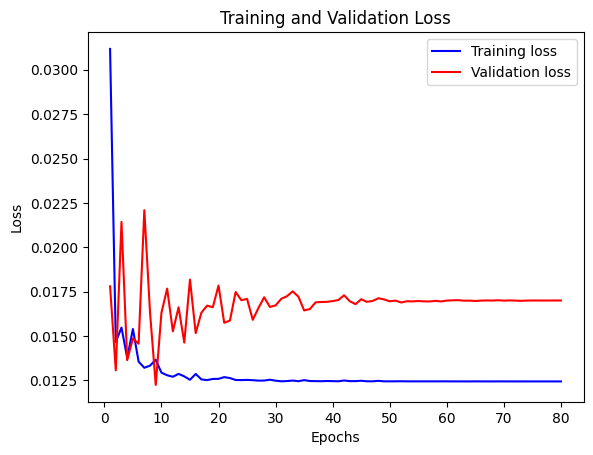

4/4 [==============================] - 0s 5ms/step
the MAPE for the 4th fold is : 1.8726661097362773%
the MAPE for this training is : 2.923210507894802%
MAPE on Test Set: 2.923210507894802%
MAE on Test Set: 0.07340133372143576
MAPE on Training Set: 2.9095370707642916%
MAE on Training Set: 0.07286275976584164


In [43]:
merged_df_train = merged_df_R_D.drop(columns = ["ISO"])

MAPE_test, MAE_test, MAPE_train, MAE_train = train_and_evaluate_yearly_basis(merged_df_train, 5)

# Printing each value
print(f"MAPE on Test Set: {MAPE_test}%")
print(f"MAE on Test Set: {MAE_test}")
print(f"MAPE on Training Set: {MAPE_train}%")
print(f"MAE on Training Set: {MAE_train}")


In [13]:
def quartile(month):
    """
    Determine the quartile (quarter) of a given month.

    This function takes an integer representing a month (1 to 12) and returns the corresponding quartile based on the calendar year:
    - 1: January to March
    - 2: April to June
    - 3: July to September
    - 4: October to December

    Parameters:
        month (int): An integer representing a month (1 to 12).

    Returns:
        int: The quartile (quarter) to which the given month belongs.
    """
    if 1 <= month <= 3:
        return 1  # January to March
    elif 4 <= month <= 6:
        return 2  # April to June
    elif 7 <= month <= 9:
        return 3  # July to September
    else:
        return 4  # October to December


In [14]:
#Loading google trends data
google_trends_data1 = pd.read_csv("google_trends_data_1")
google_trends_data2 = pd.read_csv("google_trends_data_2")
google_trends_data3 = pd.read_csv("google_trends_data_3")
google_trends_data4 = pd.read_csv("google_trends_data_4")
google_trends_data5 = pd.read_csv("google_trends_data_5")
google_trends_data6 = pd.read_csv("google_trends_data_6")



In [15]:
# Merging the dataframes
merged_data_google_trends = pd.merge(google_trends_data1, google_trends_data2, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data3, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data4, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data5, on=["Country", "year", "month","date"], how='inner')
merged_data_google_trends = pd.merge(merged_data_google_trends, google_trends_data6, on=["Country", "year", "month","date"], how='inner')

#Replacing each month with its corresponding quartile of the year
merged_data_google_trends["month"] = merged_data_google_trends["month"].apply(lambda x : quartile(x))
merged_data_google_trends.rename(columns={'month': 'quartile'}, inplace=True)
merged_data_google_trends = merged_data_google_trends.drop(columns = ["date"])

#Add a year to every row, so that google trends data match the actual predicted value of R&D expanditures
merged_data_google_trends["year"] = merged_data_google_trends["year"] +1

#Average over all values for months within a quartile
merged_data_google_trends = merged_data_google_trends.groupby(["year","Country","quartile"]).mean()
merged_data_google_trends = merged_data_google_trends.reset_index()

#replace country names with appropriate ISO encoding
replacements = {
    'CA': 'CAN', 'CH': 'CHE', 'CN': 'CHN', 'DE': 'DEU', 'FR': 'FRA', 
    'GB': 'GBR', 'JP': 'JPN', 'KR': 'KOR', 'US': 'USA', 'RU': 'RUS',
    'IT': 'ITA', 'AU': 'AUS', 'ES': 'ESP', 'NL': 'NLD', 'SE': 'SWE', 
    'FI': 'FIN', 'BE': 'BEL', 'TW': 'TWN', 'SG': 'SGP', 'AT': 'AUT', 
    'DK': 'DNK', 'NO': 'NOR', 'PL': 'POL', 'TR': 'TUR', 'PT': 'PRT', 
    'IE': 'IRL', 'CZ': 'CZE'
}

merged_data_google_trends['Country'] = merged_data_google_trends['Country'].replace(replacements, regex=True)
merged_data_google_trends.rename(columns={'Country': 'ISO'}, inplace=True)

merged_data_google_trends

year  ISO  quartile  Aerospace & Defense  Chemicals Industry  \
0    2006  CAN         1            91.333333           94.333333   
1    2006  CAN         2            74.333333           86.333333   
2    2006  CAN         3            82.000000           81.000000   
3    2006  CAN         4            65.333333           83.666667   
4    2006  CHE         1            79.666667           92.000000   
..    ...  ...       ...                  ...                 ...   
571  2021  KOR         4            76.666667           87.666667   
572  2021  USA         1            29.000000           69.333333   
573  2021  USA         2            39.333333           84.333333   
574  2021  USA         3            31.000000           76.333333   
575  2021  USA         4            28.666667           61.000000   

     Pharmaceuticals & Biotech  Computers & Electronics  Automotive Industry  \
0                    96.333333                92.000000            82.333333   
1                    86.666667                76.333333            82.000000   
2                    79.666667                72.666667            83.333333   
3                    78.000000                80.000000            78.000000   
4                    92.000000                89.000000            79.000000   
..                         ...                      ...                  ...   
571                  82.333333                92.333333            23.000000   
572                  27.000000                30.333333            30.666667   
573                  28.333333                33.000000            28.000000   
574                  29.000000                33.000000            27.000000   
575                  33.333333                29.333333            22.333333   

     Fuel Economy  Biological Sciences  ...  Jobs & Education  \
0       19.000000            87.666667  ...         85.666667   
1       21.666667            83.666667  ...         87.000000   
2       58.666667            69.333333  ...         81.000000   
3       20.000000            89.000000  ...         82.333333   
4       48.000000            92.666667  ...         90.666667   
..            ...                  ...  ...               ...   
571     69.000000            83.000000  ...         89.000000   
572     22.000000            50.333333  ...         64.000000   
573     18.666667            55.666667  ...         68.666667   
574     15.333333            55.666667  ...         61.000000   
575     14.333333            44.666667  ...         52.333333   

     Crime & Justice  Social Services  Business News  Health News   Politics  \
0          92.666667        57.333333      91.000000    15.333333  94.666667   
1          85.000000        50.333333      78.000000    17.333333  82.000000   
2          81.333333        47.000000      62.666667    12.000000  70.666667   
3          89.000000        50.666667      83.666667    21.000000  84.666667   
4          91.333333        66.333333      95.666667    26.666667  80.666667   
..               ...              ...            ...          ...        ...   
571        85.333333        87.000000      73.333333    56.000000  88.000000   
572        42.666667        44.000000      28.333333     8.333333  50.333333   
573        88.333333        74.333333      30.333333     5.000000  59.666667   
574        70.333333        49.333333      24.333333     7.333333  51.666667   
575        51.666667        45.000000      22.000000    40.333333  44.333333   

     Social Issues & Advocacy  Real Estate  Astronomy  Ecology & Environment  
0                   86.666667    66.666667  91.000000              86.000000  
1                   83.333333    48.666667  79.666667              79.000000  
2                   86.000000    39.666667  76.666667              56.000000  
3                   68.000000    49.333333  73.333333              74.333333  
4                   92.000000    72.666667  95.666667              65.000000  

In [16]:
def filter_uncorrelated_features(combined_data_quartiles, merged_df_R_D, correlation_threshold=0.12):
    """
    Filter features based on their correlation with a target variable.

    This function filters the features in the `combined_data_quartiles` DataFrame based on their correlation with the target variable 'v'
    from the `merged_df_R_D` DataFrame. Features with an absolute correlation coefficient greater than or equal to the specified
    `correlation_threshold` are retained.

    Parameters:
        combined_data_quartiles (pandas.DataFrame): The DataFrame containing features for filtering.
        merged_df_R_D (pandas.DataFrame): The DataFrame containing the target variable 'v'.
        correlation_threshold (float, optional): The minimum absolute correlation coefficient for feature retention.
            Defaults to 0.1.

    Returns:
        list of str: A list of feature names that meet the correlation threshold.
    """
    R_D_values = pd.DataFrame(merged_df_R_D[["ISO", "year", "v"]])

    # Join features (X_train) and target (y_train) to compute correlations
    # This ensures that the indices are aligned
    data = pd.merge(combined_data_quartiles, R_D_values, on=['ISO', 'year'], how='inner')

    # Compute correlation matrix
    data = data.drop(axis=1, columns=["ISO", "year"])
    correlation_matrix = data.corr()

    # Get the absolute correlation values with the target variable
    feature_correlation = correlation_matrix['v'].abs().sort_values(ascending=False)

    # Drop the target variable correlation with itself
    feature_correlation = feature_correlation.drop(labels=['v'])

    # Keep only features with correlation above or equal to the threshold
    features_kept = []
    correlations = []
    for feature, corr in feature_correlation.items():
        if correlation_threshold <= corr:
            features_kept.append(feature)
            correlations.append(corr)
    
    return features_kept,correlations


In [17]:
#Combine data of quartiles in order to use it for a yearly prediction basis
combined_data_quartiles = merged_data_google_trends.groupby(['ISO', 'year', 'quartile']).mean()
combined_data_quartiles = combined_data_quartiles.reset_index()
combined_data_quartiles = combined_data_quartiles.drop(columns=["quartile"])

#Keeping this copy for feature selection afterwards
full_combined_data_quartiles = combined_data_quartiles.copy()

#Keep only features with a minimum threshold of correlation with the output
features_kept,correlations = filter_uncorrelated_features(combined_data_quartiles,merged_df_R_D,correlation_threshold=0.12)
print(features_kept)


combined_data_quartiles = combined_data_quartiles.loc[:,features_kept+["ISO","year"]]
combined_data_quartiles

['Web Apps & Online Tools', 'Business Finance', 'Pharmaceutical Manufacturing', 'Data Management_y', 'Venture Capital', 'Pharmaceuticals & Biotech', 'Genetics', 'Automotive Industry', 'Nanobiotechnology', 'Software Utilities', 'Oil & Gas', 'Renewable Energy', 'Renewable Energy (Subcategory of Energy & Utilities)', 'Risk Management', 'Environmental Science', 'Artificial Intelligence']


Web Apps & Online Tools  Business Finance  Pharmaceutical Manufacturing  \
0                  68.333333         94.666667                     94.000000   
1                  67.666667         75.666667                     78.000000   
2                  75.000000         82.000000                     74.000000   
3                  67.666667         74.333333                     81.333333   
4                  74.333333         83.333333                     83.000000   
..                       ...               ...                           ...   
571                55.666667         59.000000                     57.000000   
572                55.333333         65.333333                     61.666667   
573                57.000000         71.000000                     52.666667   
574                52.666667         75.000000                     55.000000   
575                47.333333         63.000000                     51.000000   

     Data Management_y  Venture Capital  Pharmaceuticals & Biotech   Genetics  \
0            85.000000        51.666667                  96.333333  86.333333   
1            75.000000        46.333333                  86.666667  70.000000   
2            66.333333        35.000000                  79.666667  64.333333   
3            78.333333        46.000000                  78.000000  85.000000   
4            95.000000        44.666667                  83.333333  84.000000   
..                 ...              ...                        ...        ...   
571          51.666667        18.333333                  24.333333  34.666667   
572          53.000000        18.000000                  27.000000  37.000000   
573          54.000000        15.000000                  28.333333  31.000000   
574          53.000000        15.000000                  29.000000  27.333333   
575          48.333333        15.000000                  33.333333  29.333333   

     Automotive Industry  Nanobiotechnology  Software Utilities  Oil & Gas  \
0              82.333333          97.333333           95.000000  92.333333   
1              82.000000          83.000000           78.000000  88.333333   
2              83.333333          74.666667           77.333333  76.000000   
3              78.000000          81.000000           82.333333  80.333333   
4              77.333333          77.000000           76.666667  82.666667   
..                   ...                ...                 ...        ...   
571            41.333333          33.333333           51.666667  37.333333   
572            30.666667          34.333333           53.666667  36.000000   
573            28.000000          41.666667           54.666667  39.666667   
574            27.000000          39.333333           53.333333  36.000000   
575            22.333333          34.000000           42.666667  34.333333   

     Renewable Energy  Renewable Energy (Subcategory of Energy & Utilities)  \
0           92.000000                                          92.000000      
1           87.000000                                          87.000000      
2           76.000000                                          75.666667      
3           80.000000                                          80.000000      
4           83.333333                                          83.000000      
..                ...                                                ...      
571         36.666667                                          36.333333      
572         36.000000                                          36.000000      
573         39.666667                                          39.666667      
574         36.000000                                          35.666667      
575         34.333333                                          36.000000      

     Risk Management  Environmental Science  Artificial Intelligence  ISO  \
0          93.333333              57.000000                93.666667  CAN   
1          81.666667           

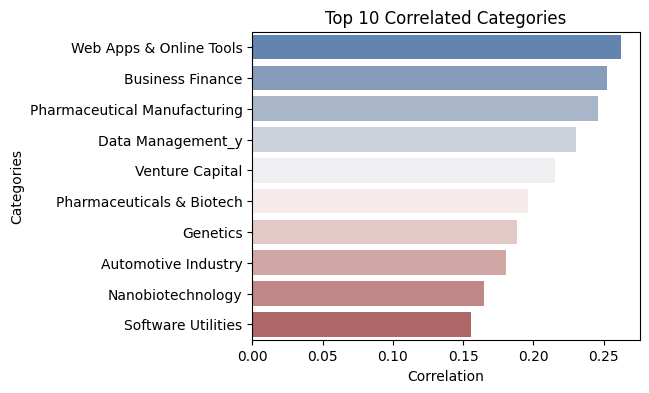

In [18]:
# Combine the lists into a list of tuples and sort by the absolute value of correlations
combined = list(zip(features_kept, correlations))
combined_sorted = sorted(combined, key=lambda x: abs(x[1]), reverse=True)

# Select the top 10 features
top_10_features = combined_sorted[:10]

# Unzip the features and their corresponding correlations
top_features, top_correlations = zip(*top_10_features)

# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=list(top_correlations), y=list(top_features), hue=list(top_features), palette="vlag", legend=False)
plt.title('Top 10 Correlated Categories')
plt.xlabel('Correlation')
plt.ylabel('Categories')
plt.savefig('correlations.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [19]:
# Merging Google Trends data and R&D expenditure values
# In this merge, 'v-2' corresponds to the R&D expenditure value from 2 years ago,
# 'v-1' corresponds to the R&D expenditure of the previous year,
# and 'v' represents the difference we aim to predict between the current year
# and the previous year's R&D expenditure value.

google_trends_data = pd.merge(first_merged, combined_data_quartiles, on=['ISO', 'year'], how='inner')
merged_data = google_trends_data.copy()
google_trends_data = google_trends_data.drop(axis =1 ,columns=["ISO","v-2"])
google_trends_data

year       v-1         v  Web Apps & Online Tools  Business Finance  \
0    2006  1.971243 -0.028245                68.333333         94.666667   
1    2006  1.971243 -0.028245                67.666667         75.666667   
2    2006  1.971243 -0.028245                75.000000         82.000000   
3    2006  1.971243 -0.028245                67.666667         74.333333   
4    2007  1.942999 -0.039421                74.333333         83.333333   
..    ...       ...       ...                      ...               ...   
507  2020  3.170487  0.297284                55.666667         59.000000   
508  2021  3.467771 -0.010725                55.333333         65.333333   
509  2021  3.467771 -0.010725                57.000000         71.000000   
510  2021  3.467771 -0.010725                52.666667         75.000000   
511  2021  3.467771 -0.010725                47.333333         63.000000   

     Pharmaceutical Manufacturing  Data Management_y  Venture Capital  \
0                       94.000000          85.000000        51.666667   
1                       78.000000          75.000000        46.333333   
2                       74.000000          66.333333        35.000000   
3                       81.333333          78.333333        46.000000   
4                       83.000000          95.000000        44.666667   
..                            ...                ...              ...   
507                     57.000000          51.666667        18.333333   
508                     61.666667          53.000000        18.000000   
509                     52.666667          54.000000        15.000000   
510                     55.000000          53.000000        15.000000   
511                     51.000000          48.333333        15.000000   

     Pharmaceuticals & Biotech   Genetics  Automotive Industry  \
0                    96.333333  86.333333            82.333333   
1                    86.666667  70.000000            82.000000   
2                    79.666667  64.333333            83.333333   
3                    78.000000  85.000000            78.000000   
4                    83.333333  84.000000            77.333333   
..                         ...        ...                  ...   
507                  24.333333  34.666667            41.333333   
508                  27.000000  37.000000            30.666667   
509                  28.333333  31.000000            28.000000   
510                  29.000000  27.333333            27.000000   
511                  33.333333  29.333333            22.333333   

     Nanobiotechnology  Software Utilities  Oil & Gas  Renewable Energy  \
0            97.333333           95.000000  92.333333         92.000000   
1            83.000000           78.000000  88.333333         87.000000   
2            74.666667           77.333333  76.000000         76.000000   
3            81.000000           82.333333  80.333333         80.000000   
4            77.000000           76.666667  82.666667         83.333333   
..                 ...                 ...        ...               ...   
507          33.333333           51.666667  37.333333         36.666667   
508          34.333333           53.666667  36.000000         36.000000   
509          41.666667           54.666667  39.666667         39.666667   
510          39.333333           53.333333  36.000000         36.000000   
511          34.000000           42.666667  34.333333         34.333333   

     Renewable Energy (Subcategory of Energy & Utilities)  Risk Management  \
0                                            92.000000           93.333333   
1                                            87.000000           81.666667   
2                                            75.666667           69.000000   
3                                            80.000000           73.333333   
4                                            83.000000           79.333333   
..                                                 ..

### R&D ESTIMATION ON A YEARLY BASIS (GOOGLE TRENDS DATA)


Epoch 1/80
41/41 [==============================] - 2s 21ms/step - loss: 14.7252 - val_loss: 0.0319 - lr: 0.0010
Epoch 2/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0559 - val_loss: 0.0216 - lr: 0.0010
Epoch 3/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0352 - val_loss: 0.1431 - lr: 0.0010
Epoch 4/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0385 - val_loss: 0.0164 - lr: 0.0010
Epoch 5/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0309 - val_loss: 0.0798 - lr: 0.0010
Epoch 6/80
41/41 [==============================] - 1s 17ms/step - loss: 0.1106 - val_loss: 0.0136 - lr: 0.0010
Epoch 7/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0154 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0127 - val_loss: 0.0218 - lr: 0.0010
Epoch 9/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0153 - val_loss: 0.0113 - lr

Epoch 72/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 5.5166e-06
Epoch 73/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.9916e-06
Epoch 74/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.5166e-06
Epoch 75/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 4.0868e-06
Epoch 76/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.6979e-06
Epoch 77/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.3460e-06
Epoch 78/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 3.0276e-06
Epoch 79/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0111 - lr: 2.7394e-06
Epoch 80/80
13/13 [==============================] - 0s 5ms/step

41/41 [==============================] - 1s 18ms/step - loss: 0.0051 - val_loss: 0.0112 - lr: 1.6573e-05
Epoch 62/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0112 - lr: 1.4996e-05
Epoch 63/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 1.3569e-05
Epoch 64/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0052 - val_loss: 0.0112 - lr: 1.2277e-05
Epoch 65/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0116 - lr: 1.1109e-05
Epoch 66/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0110 - lr: 1.0052e-05
Epoch 67/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 9.0953e-06
Epoch 68/80
41/41 [==============================] - 1s 17ms/step - loss: 0.0051 - val_loss: 0.0111 - lr: 8.2298e-06
Epoch 69/80
41/41 [==============================] - 1s 18ms/step - loss: 0.

41/41 [==============================] - 1s 18ms/step - loss: 0.0052 - val_loss: 0.0128 - lr: 4.9787e-05
Epoch 51/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0053 - val_loss: 0.0119 - lr: 4.5049e-05
Epoch 52/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0052 - val_loss: 0.0142 - lr: 4.0762e-05
Epoch 53/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0055 - val_loss: 0.0112 - lr: 3.6883e-05
Epoch 54/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0054 - val_loss: 0.0132 - lr: 3.3373e-05
Epoch 55/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0052 - val_loss: 0.0114 - lr: 3.0197e-05
Epoch 56/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0052 - val_loss: 0.0136 - lr: 2.7324e-05
Epoch 57/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0053 - val_loss: 0.0127 - lr: 2.4724e-05
Epoch 58/80
41/41 [==============================] - 1s 18ms/step - loss: 0.

41/41 [==============================] - 1s 19ms/step - loss: 0.0065 - val_loss: 0.0109 - lr: 1.4957e-04
Epoch 40/80
41/41 [==============================] - 1s 24ms/step - loss: 0.0060 - val_loss: 0.0121 - lr: 1.3534e-04
Epoch 41/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0062 - val_loss: 0.0109 - lr: 1.2246e-04
Epoch 42/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0060 - val_loss: 0.0112 - lr: 1.1080e-04
Epoch 43/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0059 - val_loss: 0.0109 - lr: 1.0026e-04
Epoch 44/80
41/41 [==============================] - 1s 18ms/step - loss: 0.0062 - val_loss: 0.0116 - lr: 9.0718e-05
Epoch 45/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - val_loss: 0.0106 - lr: 8.2085e-05
Epoch 46/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0058 - val_loss: 0.0117 - lr: 7.4274e-05
Epoch 47/80
41/41 [==============================] - 1s 20ms/step - loss: 0.

41/41 [==============================] - 1s 20ms/step - loss: 0.0073 - val_loss: 0.0167 - lr: 4.4933e-04
Epoch 29/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0070 - val_loss: 0.0098 - lr: 4.0657e-04
Epoch 30/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0100 - lr: 3.6788e-04
Epoch 31/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0061 - val_loss: 0.0107 - lr: 3.3287e-04
Epoch 32/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0072 - val_loss: 0.0097 - lr: 3.0119e-04
Epoch 33/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0066 - val_loss: 0.0105 - lr: 2.7253e-04
Epoch 34/80
41/41 [==============================] - 1s 21ms/step - loss: 0.0059 - val_loss: 0.0099 - lr: 2.4660e-04
Epoch 35/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0059 - val_loss: 0.0100 - lr: 2.2313e-04
Epoch 36/80
41/41 [==============================] - 1s 18ms/step - loss: 0.

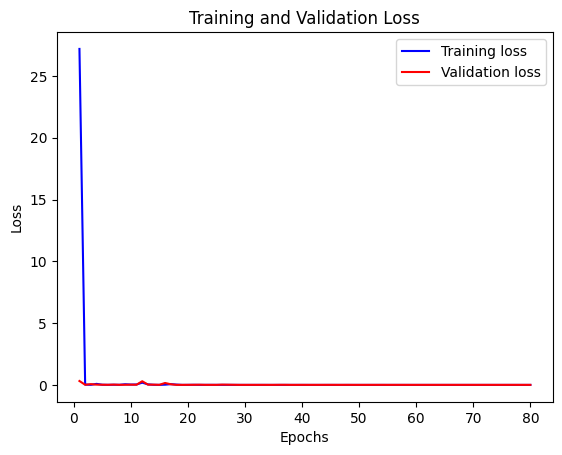

13/13 [==============================] - 0s 3ms/step
the MAPE for the 4th fold is : 2.8289599753999717%
the MAPE for this training is : 2.5329930116551393%
MAPE on Test Set: 2.5329930116551393%
MAE on Test Set: 0.0643895811520075
MAPE on Training Set: 2.139834564801866%
MAE on Training Set: 0.05502940079757566


In [20]:
MAPE_test, MAE_test, MAPE_train, MAE_train = train_and_evaluate_yearly_basis(google_trends_data,5,True)

# Printing each value
print(f"MAPE on Test Set: {MAPE_test}%")
print(f"MAE on Test Set: {MAE_test}")
print(f"MAPE on Training Set: {MAPE_train}%")
print(f"MAE on Training Set: {MAE_train}")


## Practial exemple : Predicting R&D expenditures from 2017 to 2020

For this example, we consider the training sample to be the R&D expanditures from 2005  up to 2018 , the test samples will be R&D expanditures from 2018 to 2020 included.

In [21]:
X_train = google_trends_data[google_trends_data["year"] <= 2018 ]
X_test = google_trends_data[google_trends_data["year"] >=2019]
y_test = X_test['v']
y_train = X_train['v']
previous_R_D_values = X_test["v-1"]
X_train = X_train.drop(axis=1, columns=["v-1","v","year"])
X_test = X_test.drop(axis=1, columns=["v-1","v","year"])
input_shape = X_train.shape[1]
    
# Train an NLP model
model,_ = NN_optimized(X_train, y_train, input_shape,0.001,8,epochs=80)
    
# Make predictions on the test set
y_pred = model.predict(X_test)
    
# Calculate true and predicted R&D expenditure values
R_D_true_values = previous_R_D_values + y_test
R_D_predicted_values = previous_R_D_values + y_pred.flatten()
    
# Calculate the average percentage difference for the test set
avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
print(f"The average MAPE for the test set is : {avg_percentage_diff}%")

Epoch 1/80
43/43 [==============================] - 2s 21ms/step - loss: 25.3496 - val_loss: 0.6660 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 1s 17ms/step - loss: 0.1128 - val_loss: 0.0221 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0291 - val_loss: 0.0739 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 1s 17ms/step - loss: 0.1363 - val_loss: 0.0322 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 1s 17ms/step - loss: 0.1536 - val_loss: 0.2600 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 1s 17ms/step - loss: 0.2179 - val_loss: 0.0196 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0277 - val_loss: 0.0094 - lr: 0.0010
Epoch 8/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0417 - val_loss: 0.0161 - lr: 0.0010
Epoch 9/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0188 - val_loss: 0.0203 - lr

Epoch 72/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0112 - lr: 5.5166e-06
Epoch 73/80
43/43 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0106 - lr: 4.9916e-06
Epoch 74/80
43/43 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0110 - lr: 4.5166e-06
Epoch 75/80
43/43 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0107 - lr: 4.0868e-06
Epoch 76/80
43/43 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0107 - lr: 3.6979e-06
Epoch 77/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0107 - lr: 3.3460e-06
Epoch 78/80
43/43 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0109 - lr: 3.0276e-06
Epoch 79/80
43/43 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0108 - lr: 2.7394e-06
Epoch 80/80
3/3 [==============================] - 0s 5ms/step
T

###  Difference of performance of the model between 2 countries : GREAT BRITAIN and GERMANY

Even if the model is trained using data from both countries, we will evaluate its performance on the same dataset to determine whether there is any bias in its performance towards either of the two countries. The objective here is to assess if the model demonstrates higher effectiveness or accuracy when dealing with data from one country over the other.

In [22]:
#Model perfomance on USA R&D expanditures
X_train = merged_data
X_test = X_train[X_train["ISO"] == "DEU"]
y_test = X_test['v']
y_train = X_train['v']
previous_R_D_values = X_test["v-1"]
X_train = X_train.drop(axis=1, columns=["v-1","v","year","ISO"])
X_test = X_test.drop(axis=1, columns=["v-1","v","year","ISO"])
input_shape = X_train.shape[1]
    
# Train an NLP model
model,_ = NN_optimized(X_train, y_train, input_shape,0.001,8,epochs=80)
    
# Make predictions on the test set
y_pred = model.predict(X_test)
    
# Calculate true and predicted R&D expenditure values
R_D_true_values = previous_R_D_values + y_test
R_D_predicted_values = previous_R_D_values + y_pred.flatten()
    
# Calculate the average percentage difference for the test set
avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
print(f"The MAPE for  GERMANY R&D expanditures is: {avg_percentage_diff}%")

Epoch 1/80
52/52 [==============================] - 2s 20ms/step - loss: 8.6918 - val_loss: 0.4459 - lr: 0.0010
Epoch 2/80
52/52 [==============================] - 1s 20ms/step - loss: 0.1080 - val_loss: 0.0205 - lr: 0.0010
Epoch 3/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0219 - val_loss: 0.0206 - lr: 0.0010
Epoch 4/80
52/52 [==============================] - 1s 20ms/step - loss: 0.0161 - val_loss: 0.0130 - lr: 0.0010
Epoch 5/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0216 - val_loss: 0.0105 - lr: 0.0010
Epoch 6/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0385 - val_loss: 0.0630 - lr: 0.0010
Epoch 7/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0438 - val_loss: 0.0434 - lr: 0.0010
Epoch 8/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0452 - val_loss: 0.0252 - lr: 0.0010
Epoch 9/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0299 - val_loss: 0.0231 - lr:

Epoch 72/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0051 - val_loss: 0.0106 - lr: 5.5166e-06
Epoch 73/80
52/52 [==============================] - 1s 19ms/step - loss: 0.0051 - val_loss: 0.0106 - lr: 4.9916e-06
Epoch 74/80
52/52 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0112 - lr: 4.5166e-06
Epoch 75/80
52/52 [==============================] - 1s 21ms/step - loss: 0.0052 - val_loss: 0.0109 - lr: 4.0868e-06
Epoch 76/80
52/52 [==============================] - 1s 19ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 3.6979e-06
Epoch 77/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0051 - val_loss: 0.0108 - lr: 3.3460e-06
Epoch 78/80
52/52 [==============================] - 1s 19ms/step - loss: 0.0051 - val_loss: 0.0108 - lr: 3.0276e-06
Epoch 79/80
52/52 [==============================] - 1s 20ms/step - loss: 0.0051 - val_loss: 0.0109 - lr: 2.7394e-06
Epoch 80/80
2/2 [==============================] - 0s 7ms/step
T

Now we evaluate the performance on the model on GBR R&D expanditures

In [23]:
#Model perfomance on GBR R&D expanditures
X_train = merged_data
X_test = X_train[X_train["ISO"] == "GBR"]
y_test = X_test['v']
y_train = X_train['v']
previous_R_D_values = X_test["v-1"]
X_train = X_train.drop(axis=1, columns=["v-1","v","year","ISO"])
X_test = X_test.drop(axis=1, columns=["v-1","v","year","ISO"])
input_shape = X_train.shape[1]
    
# Train an NLP model
model,_ = NN_optimized(X_train, y_train, input_shape,0.001,8,epochs=80)
    
# Make predictions on the test set
y_pred = model.predict(X_test)
    
# Calculate true and predicted R&D expenditure values
R_D_true_values = previous_R_D_values + y_test
R_D_predicted_values = previous_R_D_values + y_pred.flatten()
    
# Calculate the average percentage difference for the test set
avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
print(f"The MAPE for GREAT BRITAIN R&D expanditures is: {avg_percentage_diff}%")

Epoch 1/80
52/52 [==============================] - 3s 23ms/step - loss: 14.6877 - val_loss: 0.1175 - lr: 0.0010
Epoch 2/80
52/52 [==============================] - 1s 19ms/step - loss: 0.2364 - val_loss: 0.1159 - lr: 0.0010
Epoch 3/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0835 - val_loss: 0.0247 - lr: 0.0010
Epoch 4/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0193 - val_loss: 0.0166 - lr: 0.0010
Epoch 5/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0150 - val_loss: 0.0138 - lr: 0.0010
Epoch 6/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0126 - val_loss: 0.0186 - lr: 0.0010
Epoch 7/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0650 - val_loss: 0.0756 - lr: 0.0010
Epoch 8/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0314 - val_loss: 0.0852 - lr: 0.0010
Epoch 9/80
52/52 [==============================] - 1s 20ms/step - loss: 0.0345 - val_loss: 0.0345 - lr

Epoch 72/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0049 - val_loss: 0.0106 - lr: 5.5166e-06
Epoch 73/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0105 - lr: 4.9916e-06
Epoch 74/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0110 - lr: 4.5166e-06
Epoch 75/80
52/52 [==============================] - 1s 25ms/step - loss: 0.0050 - val_loss: 0.0108 - lr: 4.0868e-06
Epoch 76/80
52/52 [==============================] - 1s 18ms/step - loss: 0.0049 - val_loss: 0.0108 - lr: 3.6979e-06
Epoch 77/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0107 - lr: 3.3460e-06
Epoch 78/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0107 - lr: 3.0276e-06
Epoch 79/80
52/52 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0108 - lr: 2.7394e-06
Epoch 80/80
2/2 [==============================] - 0s 6ms/step
T

## Choices of parameters

### 1 -  NN width

In [24]:
NN_widths = [64,128,256,512,1024,2048,4096,8192,16384,32768]

# List to store average percentage differences for each width
avg_percentages_diffs_NN_widths = []


#Evaluating for Width 64
print("Evaluating for NN_width 64")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_64)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 128
print("Evaluating for NN_width 128")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_128)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 256
print("Evaluating for NN_width 256")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_256)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 512
print("Evaluating for NN_width 512")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_512)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 1024
print("Evaluating for NN_width 1024")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_1024)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 2048
print("Evaluating for NN_width 2048")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_2048)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 4096
print("Evaluating for NN_width 4096")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_4096)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 8192
print("Evaluating for NN_width 8192")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_8192)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 16384
print("Evaluating for NN_width 16384")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_16384)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)

#Evaluating for Width 32768
print("Evaluating for NN_width 32768")
avg_percentages_diffs_NN_width = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_width_32768)
avg_percentages_diffs_NN_widths.append(avg_percentages_diffs_NN_width)


Evaluating for NN_width 64
Epoch 1/80
17/17 [==============================] - 1s 13ms/step - loss: 40.0648 - val_loss: 20.3646 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 5ms/step - loss: 14.0255 - val_loss: 17.9987 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 6ms/step - loss: 10.2578 - val_loss: 9.9796 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 5ms/step - loss: 7.8386 - val_loss: 8.8822 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 4ms/step - loss: 6.2353 - val_loss: 6.3471 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 5ms/step - loss: 4.9808 - val_loss: 5.4076 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 6ms/step - loss: 4.1339 - val_loss: 4.7702 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 5ms/step - loss: 3.6471 - val_loss: 4.2789 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 5ms/step - loss: 3.0507 

17/17 [==============================] - 0s 5ms/step - loss: 0.6264 - val_loss: 0.9994 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 3ms/step - loss: 0.6259 - val_loss: 1.0011 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 3ms/step - loss: 0.6252 - val_loss: 0.9990 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 4ms/step - loss: 0.6246 - val_loss: 0.9985 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 5ms/step - loss: 0.6245 - val_loss: 0.9982 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 4ms/step - loss: 0.6245 - val_loss: 0.9976 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 5ms/step - loss: 0.6240 - val_loss: 0.9987 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 5ms/step - loss: 0.6242 - val_loss: 1.0003 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 0s/step
The MAPE for the test 

17/17 [==============================] - 0s 3ms/step - loss: 0.0982 - val_loss: 0.1501 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0972 - val_loss: 0.1494 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0951 - val_loss: 0.1500 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0954 - val_loss: 0.1496 - lr: 2.0242e-05
Epoch 60/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0952 - val_loss: 0.1507 - lr: 1.8316e-05
Epoch 61/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0947 - val_loss: 0.1505 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0949 - val_loss: 0.1506 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0949 - val_loss: 0.1500 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 3ms/step - loss: 0.0945 - va

17/17 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 0.2139 - lr: 1.3534e-04
Epoch 41/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0613 - val_loss: 0.2173 - lr: 1.2246e-04
Epoch 42/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0604 - val_loss: 0.2245 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0597 - val_loss: 0.2161 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.2133 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0584 - val_loss: 0.2129 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0576 - val_loss: 0.2125 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0579 - val_loss: 0.2151 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 3ms/step - loss: 0.0567 - va

17/17 [==============================] - 0s 5ms/step - loss: 1.1076 - val_loss: 1.7989 - lr: 3.6788e-04
Epoch 31/80
17/17 [==============================] - 0s 4ms/step - loss: 1.1051 - val_loss: 1.8534 - lr: 3.3287e-04
Epoch 32/80
17/17 [==============================] - 0s 5ms/step - loss: 1.0687 - val_loss: 1.6945 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 0s 6ms/step - loss: 1.0570 - val_loss: 1.8713 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 4ms/step - loss: 1.0673 - val_loss: 1.6443 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 4ms/step - loss: 1.0881 - val_loss: 1.6369 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 0s 4ms/step - loss: 1.0388 - val_loss: 1.7283 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 0s 5ms/step - loss: 1.0335 - val_loss: 1.6622 - lr: 1.8268e-04
Epoch 38/80
17/17 [==============================] - 0s 6ms/step - loss: 1.0162 - va

17/17 [==============================] - 0s 5ms/step - loss: 0.0280 - val_loss: 0.0735 - lr: 0.0010
Epoch 21/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0248 - val_loss: 0.0362 - lr: 9.0484e-04
Epoch 22/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0478 - lr: 8.1873e-04
Epoch 23/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0349 - lr: 7.4082e-04
Epoch 24/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0261 - lr: 6.7032e-04
Epoch 25/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0347 - lr: 6.0653e-04
Epoch 26/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0335 - lr: 5.4881e-04
Epoch 27/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0269 - lr: 4.9659e-04
Epoch 28/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0172 - val_lo

17/17 [==============================] - 0s 6ms/step - loss: 0.0285 - val_loss: 0.0390 - lr: 0.0010
Epoch 11/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 0.0520 - lr: 0.0010
Epoch 12/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.0427 - lr: 0.0010
Epoch 13/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0338 - lr: 0.0010
Epoch 14/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0337 - lr: 0.0010
Epoch 15/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0298 - lr: 0.0010
Epoch 16/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0529 - lr: 0.0010
Epoch 17/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0274 - lr: 0.0010
Epoch 18/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0377 - lr: 0.0010
Epoc

4/4 [==============================] - 0s 2ms/step
The MAPE for the test set is: 4.757982722903556%
Evaluating for NN_width 4096
Epoch 1/80
17/17 [==============================] - 1s 13ms/step - loss: 207.2088 - val_loss: 42.9275 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 7ms/step - loss: 25.1716 - val_loss: 19.6957 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 5ms/step - loss: 6.7843 - val_loss: 0.4838 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 4ms/step - loss: 0.9583 - val_loss: 0.4342 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 6ms/step - loss: 0.3760 - val_loss: 0.2345 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 4ms/step - loss: 0.1555 - val_loss: 0.1645 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0832 - val_loss: 0.1269 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0601 - val_los

17/17 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0137 - lr: 6.0967e-06
Epoch 72/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0137 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0056 - va

17/17 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0126 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0126 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0126 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0126 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0126 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0126 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0126 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0126 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0064 - va

17/17 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0089 - lr: 4.5049e-05
Epoch 52/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0089 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0089 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0089 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0088 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0088 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0088 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0088 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0070 - va

17/17 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0100 - lr: 1.2246e-04
Epoch 42/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0096 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0102 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 10ms/step - loss: 0.0073 - val_loss: 0.0096 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0100 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0096 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0098 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0096 - lr: 6.0810e-05
Epoch 49/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0071 -

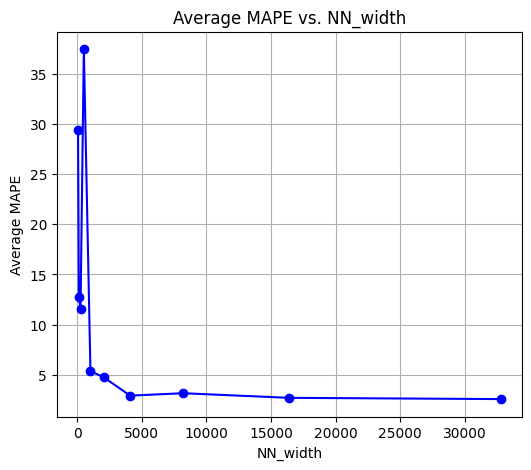

In [25]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(NN_widths, avg_percentages_diffs_NN_widths, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. NN_width')
plt.xlabel('NN_width')
plt.ylabel('Average MAPE')
plt.grid(True)
# Save the plot as a PDF
plt.savefig('width.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

### 2- NN depth

In [26]:
NN_depths = [1,3,5,7,8,9,10,11]

# List to store average percentage differences for each depth
avg_percentages_diffs_NN_depths = []


#Evaluating for Depth 1
print("Evaluating for NN_depth 1")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_1)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 3
print("Evaluating for NN_depth 3")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_3)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 5
print("Evaluating for NN_depth 5")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_5)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 7
print("Evaluating for NN_depth 7")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_7)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 8
print("Evaluating for NN_depth 8")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_8)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 9
print("Evaluating for NN_depth 9")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_9)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 10
print("Evaluating for NN_depth 10")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_10)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)

#Evaluating for Depth 11
print("Evaluating for NN_depth 11")
avg_percentages_diffs_NN_depth = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,f=NLP_depth_11)
avg_percentages_diffs_NN_depths.append(avg_percentages_diffs_NN_depth)



Evaluating for NN_depth 1
Epoch 1/80
17/17 [==============================] - 1s 16ms/step - loss: 719.7039 - val_loss: 230.8444 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 6ms/step - loss: 63.7195 - val_loss: 37.8013 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 7ms/step - loss: 12.9127 - val_loss: 8.6958 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 8ms/step - loss: 3.1538 - val_loss: 1.5544 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 8ms/step - loss: 0.5891 - val_loss: 0.1516 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 7ms/step - loss: 0.1838 - val_loss: 0.1495 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0733 - val_loss: 0.0720 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0393 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 7ms/step - loss: 0.0312

17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0092 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 5ms/step
The MAPE for the test

Epoch 62/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0047 - val_loss: 0.0078 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0046 - val_loss: 0.0077 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0078 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0077 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0078 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0046 - val_loss: 0.0077 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 0.0078 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0046 - val_loss: 0.0077 - lr: 7.4466e-06
Epoch 70/80
17/17 [==============================] - 0s 25ms/ste

Epoch 52/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0079 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0078 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 19ms/step - loss: 0.0056 - val_loss: 0.0079 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.0079 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0055 - val_loss: 0.0080 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0078 - lr: 2.2371e-05
Epoch 59/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0080 - lr: 2.0242e-05
Epoch 60/80
17/17 [==============================] - 0s 20ms/ste

Epoch 42/80
17/17 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0075 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0.0091 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 19ms/step - loss: 0.0066 - val_loss: 0.0085 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0060 - val_loss: 0.0076 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0075 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0075 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0076 - lr: 6.0810e-05
Epoch 49/80
17/17 [==============================] - 0s 19ms/step - loss: 0.0057 - val_loss: 0.0083 - lr: 5.5023e-05
Epoch 50/80
17/17 [==============================] - 0s 20ms/ste

Epoch 32/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0100 - val_loss: 0.0180 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0102 - val_loss: 0.0107 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0069 - val_loss: 0.0080 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0083 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0082 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0060 - val_loss: 0.0079 - lr: 1.8268e-04
Epoch 38/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0074 - val_loss: 0.0093 - lr: 1.6530e-04
Epoch 39/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0085 - val_loss: 0.0081 - lr: 1.4957e-04
Epoch 40/80
17/17 [==============================] - 0s 22ms/ste

Epoch 22/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0080 - val_loss: 0.0092 - lr: 8.1873e-04
Epoch 23/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0073 - val_loss: 0.0095 - lr: 7.4082e-04
Epoch 24/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0072 - val_loss: 0.0082 - lr: 6.7032e-04
Epoch 25/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0071 - val_loss: 0.0082 - lr: 6.0653e-04
Epoch 26/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0068 - val_loss: 0.0084 - lr: 5.4881e-04
Epoch 27/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0130 - lr: 4.9659e-04
Epoch 28/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 4.4933e-04
Epoch 29/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0069 - val_loss: 0.0082 - lr: 4.0657e-04
Epoch 30/80
17/17 [==============================] - 0s 21ms/ste

17/17 [==============================] - 0s 24ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 0.0010
Epoch 12/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 13/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 14/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 15/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 16/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0120 - val_loss: 0.0133 - lr: 0.0010
Epoch 17/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 18/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.0010
Epoch 19/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 0.

Epoch 1/80
17/17 [==============================] - 3s 35ms/step - loss: 0.0271 - val_loss: 0.0160 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0145 - val_loss: 0.0152 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0137 - val_loss: 0.0145 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0131 - val_loss: 0.0140 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0126 - val_loss: 0.0137 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0124 - val_loss: 0.0135 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0122 - val_loss: 0.0134 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0134 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0121 - val_loss: 0.0134 - lr:

Epoch 72/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0120 - val_loss: 0.0134 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 9ms/step
T

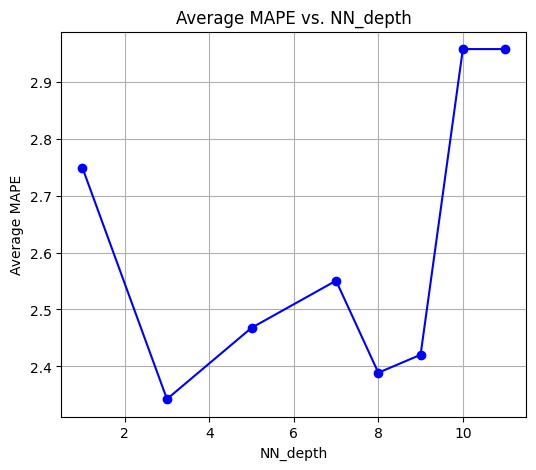

In [27]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(NN_depths, avg_percentages_diffs_NN_depths, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. NN_depth')
plt.xlabel('NN_depth')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('depth.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()


### 3 - correlation threshold

In [28]:
# List of correlation thresholds to test
correlation_thresholds = [0.1, 0.12, 0.14,0.16,0.2]

# List to store average percentage differences for each threshold
avg_percentages_diffs = []

# Loop through each correlation threshold
for correlation_threshold in correlation_thresholds:
    print(f"Testing performance for threshold : {correlation_threshold}")
    
    # Keep only features with a minimum threshold of correlation with the output
    features_kept_test,_ = filter_uncorrelated_features(full_combined_data_quartiles, merged_df_R_D, correlation_threshold=correlation_threshold)

    # Create a DataFrame with selected features and additional columns "ISO" and "year"
    combined_data_quartiles_test = full_combined_data_quartiles.loc[:, features_kept_test + ["ISO", "year"]]

    # Merge the selected features with Google Trends data based on "ISO" and "year"
    google_trends_data_test = pd.merge(first_merged, combined_data_quartiles_test, on=['ISO', 'year'], how='inner')

    # Drop columns "ISO" and "v-2" from the merged DataFrame
    google_trends_data_test = google_trends_data_test.drop(axis=1, columns=["ISO", "v-2"])

    # Train and evaluate the model with the selected data and calculate the average percentage difference
    avg_percentage_diff = train_and_evaluate_yearly_basis_select_parameters(google_trends_data_test, True)

    # Append the average percentage difference to the list
    avg_percentages_diffs.append(avg_percentage_diff)


    

Testing performance for threshold : 0.1
Epoch 1/80
17/17 [==============================] - 2s 36ms/step - loss: 78.8300 - val_loss: 1.1657 - lr: 0.0010
Epoch 2/80
17/17 [==============================] - 0s 21ms/step - loss: 0.3957 - val_loss: 0.0422 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0267 - val_loss: 0.0205 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0235 - val_loss: 0.0423 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0295 - val_loss: 0.0175 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0428 - val_loss: 0.1297 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0862 - val_loss: 0.1532 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0863 - val_loss: 0.3063 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 20ms/ste

17/17 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 6.0967e-06
Epoch 72/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 5.5166e-06
Epoch 73/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0085 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0085 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 19ms/step - loss: 0.

Epoch 61/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0047 - val_loss: 0.0074 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0047 - val_loss: 0.0074 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0047 - val_loss: 0.0073 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0047 - val_loss: 0.0073 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0047 - val_loss: 0.0073 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0074 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0047 - val_loss: 0.0073 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0073 - lr: 8.2298e-06
Epoch 69/80
17/17 [==============================] - 0s 21ms/ste

17/17 [==============================] - 0s 22ms/step - loss: 0.0062 - val_loss: 0.0083 - lr: 4.9787e-05
Epoch 51/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0065 - val_loss: 0.0079 - lr: 4.5049e-05
Epoch 52/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 4.0762e-05
Epoch 53/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0079 - lr: 3.6883e-05
Epoch 54/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0078 - lr: 3.3373e-05
Epoch 55/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0062 - val_loss: 0.0079 - lr: 3.0197e-05
Epoch 56/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0078 - lr: 2.7324e-05
Epoch 57/80
17/17 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0080 - lr: 2.4724e-05
Epoch 58/80
17/17 [==============================] - 0s 22ms/step - loss: 0.

Epoch 40/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.3534e-04
Epoch 41/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0118 - lr: 1.2246e-04
Epoch 42/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0087 - lr: 1.1080e-04
Epoch 43/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0101 - lr: 1.0026e-04
Epoch 44/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0065 - val_loss: 0.0090 - lr: 9.0718e-05
Epoch 45/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0060 - val_loss: 0.0089 - lr: 8.2085e-05
Epoch 46/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0084 - lr: 7.4274e-05
Epoch 47/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0058 - val_loss: 0.0086 - lr: 6.7206e-05
Epoch 48/80
17/17 [==============================] - 0s 25ms/ste

17/17 [==============================] - 0s 25ms/step - loss: 0.0085 - val_loss: 0.0094 - lr: 4.0657e-04
Epoch 30/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0101 - val_loss: 0.0089 - lr: 3.6788e-04
Epoch 31/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0100 - val_loss: 0.0138 - lr: 3.3287e-04
Epoch 32/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0103 - lr: 3.0119e-04
Epoch 33/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0088 - lr: 2.7253e-04
Epoch 34/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0074 - val_loss: 0.0103 - lr: 2.4660e-04
Epoch 35/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0081 - val_loss: 0.0084 - lr: 2.2313e-04
Epoch 36/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0072 - val_loss: 0.0085 - lr: 2.0190e-04
Epoch 37/80
17/17 [==============================] - 0s 24ms/step - loss: 0.

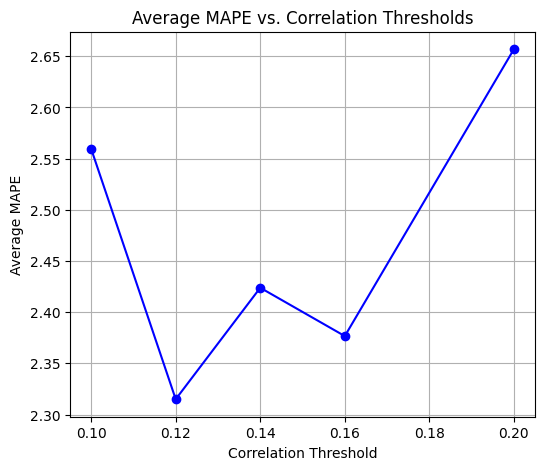

In [29]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(correlation_thresholds, avg_percentages_diffs, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Correlation Thresholds')
plt.xlabel('Correlation Threshold')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('correlations_plot.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()



### 4 - initial learning rate

In [48]:
# List of initial_rates for NN optimization to test
initial_rates = [0.00001,0.001,0.01,0.1]

# List to store average percentage differences for each initial_rate
avg_percentages_diffs_initial_rates = []

# Loop through each initial_rate
for initial_rate in initial_rates:
    print(f"Testing performance for initial_rate : {initial_rate}")
    avg_percentages_diffs_initial_rate = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,initial_rate=initial_rate)

    # Append the average percentage difference to the list
    avg_percentages_diffs_initial_rates.append(avg_percentages_diffs_initial_rate)

Testing performance for initial_rate : 1e-05
Epoch 1/80
17/17 [==============================] - 2s 40ms/step - loss: 0.5246 - val_loss: 0.0511 - lr: 1.0000e-05
Epoch 2/80
17/17 [==============================] - 1s 32ms/step - loss: 0.1064 - val_loss: 0.0376 - lr: 1.0000e-05
Epoch 3/80
17/17 [==============================] - 0s 29ms/step - loss: 0.0342 - val_loss: 0.0279 - lr: 1.0000e-05
Epoch 4/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0231 - val_loss: 0.0317 - lr: 1.0000e-05
Epoch 5/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0176 - val_loss: 0.0190 - lr: 1.0000e-05
Epoch 6/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0128 - val_loss: 0.0171 - lr: 1.0000e-05
Epoch 7/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0103 - val_loss: 0.0175 - lr: 1.0000e-05
Epoch 8/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0167 - lr: 1.0000e-05
Epoch 9/80
17/17 [=========

Epoch 71/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 6.0967e-08
Epoch 72/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 5.5166e-08
Epoch 73/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 4.9916e-08
Epoch 74/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 4.5166e-08
Epoch 75/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 4.0868e-08
Epoch 76/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 3.6979e-08
Epoch 77/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 3.3460e-08
Epoch 78/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0125 - lr: 3.0276e-08
Epoch 79/80
17/17 [==============================] - 0s 25ms/ste

17/17 [==============================] - 0s 24ms/step - loss: 0.0060 - val_loss: 0.0078 - lr: 1.8316e-05
Epoch 61/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.6573e-05
Epoch 62/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.4996e-05
Epoch 63/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.3569e-05
Epoch 64/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0078 - lr: 1.2277e-05
Epoch 65/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0059 - val_loss: 0.0078 - lr: 1.1109e-05
Epoch 66/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0059 - val_loss: 0.0078 - lr: 1.0052e-05
Epoch 67/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0059 - val_loss: 0.0078 - lr: 9.0953e-06
Epoch 68/80
17/17 [==============================] - 0s 24ms/step - loss: 0.

17/17 [==============================] - 0s 21ms/step - loss: 0.0105 - val_loss: 0.0120 - lr: 4.9787e-04
Epoch 51/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0104 - val_loss: 0.0120 - lr: 4.5049e-04
Epoch 52/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0105 - val_loss: 0.0120 - lr: 4.0762e-04
Epoch 53/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0120 - lr: 3.6883e-04
Epoch 54/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0120 - lr: 3.3373e-04
Epoch 55/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0105 - val_loss: 0.0120 - lr: 3.0197e-04
Epoch 56/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0105 - val_loss: 0.0120 - lr: 2.7324e-04
Epoch 57/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0120 - lr: 2.4724e-04
Epoch 58/80
17/17 [==============================] - 0s 23ms/step - loss: 0.

17/17 [==============================] - 1s 30ms/step - loss: 0.0351 - val_loss: 0.0321 - lr: 0.0150
Epoch 40/80
17/17 [==============================] - 1s 35ms/step - loss: 0.0349 - val_loss: 0.0322 - lr: 0.0135
Epoch 41/80
17/17 [==============================] - 1s 35ms/step - loss: 0.0350 - val_loss: 0.0321 - lr: 0.0122
Epoch 42/80
17/17 [==============================] - 1s 36ms/step - loss: 0.0351 - val_loss: 0.0321 - lr: 0.0111
Epoch 43/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0347 - val_loss: 0.0321 - lr: 0.0100
Epoch 44/80
17/17 [==============================] - 1s 37ms/step - loss: 0.0351 - val_loss: 0.0321 - lr: 0.0091
Epoch 45/80
17/17 [==============================] - 1s 35ms/step - loss: 0.0349 - val_loss: 0.0321 - lr: 0.0082
Epoch 46/80
17/17 [==============================] - 1s 35ms/step - loss: 0.0349 - val_loss: 0.0321 - lr: 0.0074
Epoch 47/80
17/17 [==============================] - 0s 28ms/step - loss: 0.0349 - val_loss: 0.0321 - lr: 0.

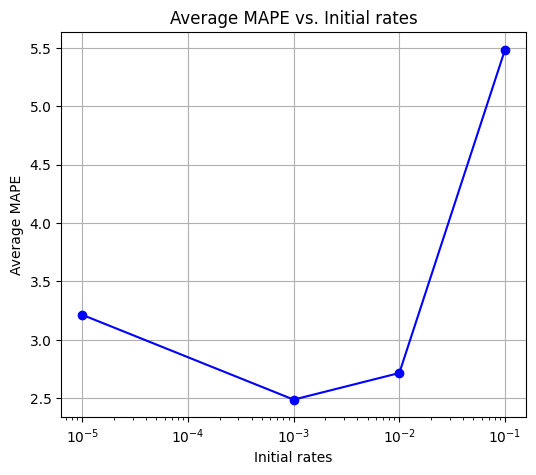

In [49]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(initial_rates, avg_percentages_diffs_initial_rates, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Initial rates')
plt.xlabel('Initial rates')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.savefig('learning_rates.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()


### 5 - Batch size

In [32]:
# List of batch sizes to test
batch_sizes = [7,8,10,15,25,35,45]

# List to store average percentage differences for each batch size
avg_percentages_diffs_batch_sizes = []

for batch_size in batch_sizes:
    print(f"Testing performance for batch_size : {batch_size}")
    avg_percentages_diffs_batch_size = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,batch_size=batch_size)

    # Append the average percentage difference to the list
    avg_percentages_diffs_batch_sizes.append(avg_percentages_diffs_batch_size)

Testing performance for batch_size : 7
Epoch 1/80
47/47 [==============================] - 3s 30ms/step - loss: 17.4959 - val_loss: 0.0328 - lr: 0.0010
Epoch 2/80
47/47 [==============================] - 1s 23ms/step - loss: 0.0522 - val_loss: 0.0333 - lr: 0.0010
Epoch 3/80
47/47 [==============================] - 2s 33ms/step - loss: 0.0272 - val_loss: 0.1129 - lr: 0.0010
Epoch 4/80
47/47 [==============================] - 1s 27ms/step - loss: 0.0538 - val_loss: 0.0221 - lr: 0.0010
Epoch 5/80
47/47 [==============================] - 1s 23ms/step - loss: 0.0283 - val_loss: 0.2717 - lr: 0.0010
Epoch 6/80
47/47 [==============================] - 1s 23ms/step - loss: 0.0858 - val_loss: 0.0626 - lr: 0.0010
Epoch 7/80
47/47 [==============================] - 1s 24ms/step - loss: 0.0769 - val_loss: 0.0753 - lr: 0.0010
Epoch 8/80
47/47 [==============================] - 1s 24ms/step - loss: 0.0225 - val_loss: 0.0113 - lr: 0.0010
Epoch 9/80
47/47 [==============================] - 1s 25ms/step

47/47 [==============================] - 1s 19ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 6.0967e-06
Epoch 72/80
47/47 [==============================] - 1s 22ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 5.5166e-06
Epoch 73/80
47/47 [==============================] - 1s 20ms/step - loss: 0.0044 - val_loss: 0.0074 - lr: 4.9916e-06
Epoch 74/80
47/47 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 0.0073 - lr: 4.5166e-06
Epoch 75/80
47/47 [==============================] - 1s 18ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 4.0868e-06
Epoch 76/80
47/47 [==============================] - 1s 18ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 3.6979e-06
Epoch 77/80
47/47 [==============================] - 1s 19ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 3.3460e-06
Epoch 78/80
47/47 [==============================] - 1s 20ms/step - loss: 0.0044 - val_loss: 0.0073 - lr: 3.0276e-06
Epoch 79/80
47/47 [==============================] - 1s 19ms/step - loss: 0.

Epoch 61/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 1.6573e-05
Epoch 62/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0076 - lr: 1.4996e-05
Epoch 63/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 1.3569e-05
Epoch 64/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0073 - lr: 1.2277e-05
Epoch 65/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0073 - lr: 1.1109e-05
Epoch 66/80
41/41 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 1.0052e-05
Epoch 67/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 9.0953e-06
Epoch 68/80
41/41 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 8.2298e-06
Epoch 69/80
41/41 [==============================] - 1s 20ms/ste

33/33 [==============================] - 1s 20ms/step - loss: 0.0051 - val_loss: 0.0076 - lr: 4.9787e-05
Epoch 51/80
33/33 [==============================] - 1s 19ms/step - loss: 0.0050 - val_loss: 0.0076 - lr: 4.5049e-05
Epoch 52/80
33/33 [==============================] - 1s 20ms/step - loss: 0.0059 - val_loss: 0.0087 - lr: 4.0762e-05
Epoch 53/80
33/33 [==============================] - 1s 23ms/step - loss: 0.0054 - val_loss: 0.0078 - lr: 3.6883e-05
Epoch 54/80
33/33 [==============================] - 1s 21ms/step - loss: 0.0050 - val_loss: 0.0076 - lr: 3.3373e-05
Epoch 55/80
33/33 [==============================] - 1s 20ms/step - loss: 0.0050 - val_loss: 0.0076 - lr: 3.0197e-05
Epoch 56/80
33/33 [==============================] - 1s 22ms/step - loss: 0.0049 - val_loss: 0.0078 - lr: 2.7324e-05
Epoch 57/80
33/33 [==============================] - 1s 20ms/step - loss: 0.0050 - val_loss: 0.0081 - lr: 2.4724e-05
Epoch 58/80
33/33 [==============================] - 1s 30ms/step - loss: 0.

Epoch 40/80
22/22 [==============================] - 0s 21ms/step - loss: 0.0069 - val_loss: 0.0082 - lr: 1.3534e-04
Epoch 41/80
22/22 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0102 - lr: 1.2246e-04
Epoch 42/80
22/22 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0089 - lr: 1.1080e-04
Epoch 43/80
22/22 [==============================] - 0s 21ms/step - loss: 0.0076 - val_loss: 0.0110 - lr: 1.0026e-04
Epoch 44/80
22/22 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0081 - lr: 9.0718e-05
Epoch 45/80
22/22 [==============================] - 0s 21ms/step - loss: 0.0061 - val_loss: 0.0089 - lr: 8.2085e-05
Epoch 46/80
22/22 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0086 - lr: 7.4274e-05
Epoch 47/80
22/22 [==============================] - 0s 20ms/step - loss: 0.0061 - val_loss: 0.0081 - lr: 6.7206e-05
Epoch 48/80
22/22 [==============================] - 0s 20ms/ste

14/14 [==============================] - 0s 22ms/step - loss: 0.0087 - val_loss: 0.0161 - lr: 4.0657e-04
Epoch 30/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0128 - val_loss: 0.0143 - lr: 3.6788e-04
Epoch 31/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0119 - val_loss: 0.0085 - lr: 3.3287e-04
Epoch 32/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0076 - val_loss: 0.0122 - lr: 3.0119e-04
Epoch 33/80
14/14 [==============================] - 0s 21ms/step - loss: 0.0076 - val_loss: 0.0096 - lr: 2.7253e-04
Epoch 34/80
14/14 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0095 - lr: 2.4660e-04
Epoch 35/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0074 - val_loss: 0.0087 - lr: 2.2313e-04
Epoch 36/80
14/14 [==============================] - 0s 22ms/step - loss: 0.0077 - val_loss: 0.0208 - lr: 2.0190e-04
Epoch 37/80
14/14 [==============================] - 0s 22ms/step - loss: 0.

10/10 [==============================] - 0s 24ms/step - loss: 0.1839 - val_loss: 0.1505 - lr: 0.0010
Epoch 19/80
10/10 [==============================] - 0s 23ms/step - loss: 0.2215 - val_loss: 0.2822 - lr: 0.0010
Epoch 20/80
10/10 [==============================] - 0s 24ms/step - loss: 0.1229 - val_loss: 0.0380 - lr: 0.0010
Epoch 21/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0480 - val_loss: 0.0117 - lr: 9.0484e-04
Epoch 22/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0145 - val_loss: 0.0149 - lr: 8.1873e-04
Epoch 23/80
10/10 [==============================] - 0s 26ms/step - loss: 0.0108 - val_loss: 0.0098 - lr: 7.4082e-04
Epoch 24/80
10/10 [==============================] - 0s 24ms/step - loss: 0.0080 - val_loss: 0.0091 - lr: 6.7032e-04
Epoch 25/80
10/10 [==============================] - 0s 23ms/step - loss: 0.0079 - val_loss: 0.0140 - lr: 6.0653e-04
Epoch 26/80
10/10 [==============================] - 0s 25ms/step - loss: 0.0101 - val_l

8/8 [==============================] - 0s 29ms/step - loss: 0.0758 - val_loss: 0.1387 - lr: 0.0010
Epoch 8/80
8/8 [==============================] - 0s 25ms/step - loss: 0.0664 - val_loss: 0.0300 - lr: 0.0010
Epoch 9/80
8/8 [==============================] - 0s 23ms/step - loss: 0.0200 - val_loss: 0.0123 - lr: 0.0010
Epoch 10/80
8/8 [==============================] - 0s 26ms/step - loss: 0.0141 - val_loss: 0.0287 - lr: 0.0010
Epoch 11/80
8/8 [==============================] - 0s 31ms/step - loss: 0.0166 - val_loss: 0.0100 - lr: 0.0010
Epoch 12/80
8/8 [==============================] - 0s 30ms/step - loss: 0.0114 - val_loss: 0.0108 - lr: 0.0010
Epoch 13/80
8/8 [==============================] - 0s 26ms/step - loss: 0.0112 - val_loss: 0.0140 - lr: 0.0010
Epoch 14/80
8/8 [==============================] - 0s 27ms/step - loss: 0.0097 - val_loss: 0.0100 - lr: 0.0010
Epoch 15/80
8/8 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 0.0132 - lr: 0.0010
Epoch 16/80
8/8

Epoch 79/80
8/8 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0087 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 0s/step
The MAPE for the test set is: 2.416676295094758%


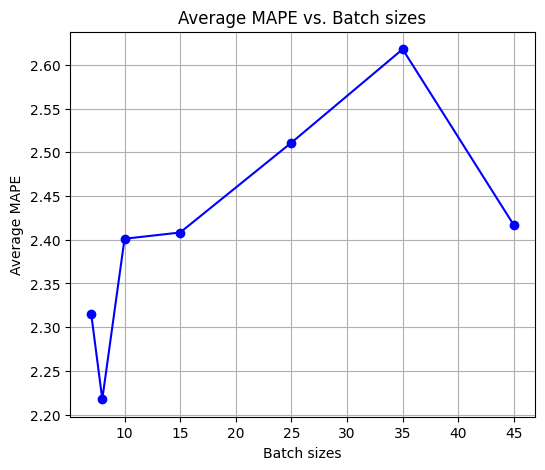

In [33]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(batch_sizes, avg_percentages_diffs_batch_sizes, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Batch sizes')
plt.xlabel('Batch sizes')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('batch_sizes.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()

### 6 - Number of epochs


In [34]:
# List of number of epochs to test
epochs = [5,10,20,40,60,80,100,120,140]

# List to store average percentage differences for each number of epochs
avg_percentages_diffs_epochs = []

for epoch in epochs:
    print(f"Testing performance for epochs : {epoch}")
    avg_percentages_diffs_epoch = train_and_evaluate_yearly_basis_select_parameters(google_trends_data, True,epochs=epoch)

    # Append the average percentage difference to the list
    avg_percentages_diffs_epochs.append(avg_percentages_diffs_epoch)

Testing performance for epochs : 5
Epoch 1/5
17/17 [==============================] - 2s 33ms/step - loss: 49.4440 - val_loss: 1.2922 - lr: 0.0010
Epoch 2/5
17/17 [==============================] - 0s 25ms/step - loss: 0.4747 - val_loss: 0.3035 - lr: 0.0010
Epoch 3/5
17/17 [==============================] - 0s 23ms/step - loss: 0.1026 - val_loss: 0.0286 - lr: 0.0010
Epoch 4/5
17/17 [==============================] - 0s 26ms/step - loss: 0.0148 - val_loss: 0.0199 - lr: 0.0010
Epoch 5/5
4/4 [==============================] - 0s 2ms/step
The MAPE for the test set is: 3.0562682304805526%
Testing performance for epochs : 10
Epoch 1/10
17/17 [==============================] - 2s 32ms/step - loss: 48.7164 - val_loss: 0.0305 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - 0s 23ms/step - loss: 1.1391 - val_loss: 0.8793 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - 0s 21ms/step - loss: 0.6953 - val_loss: 0.6275 - lr: 0.0010
Epoch 4/10
17/17 [==================

17/17 [==============================] - 0s 22ms/step - loss: 0.0078 - val_loss: 0.0080 - lr: 2.4660e-04
Epoch 35/40
17/17 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 0.0088 - lr: 2.2313e-04
Epoch 36/40
17/17 [==============================] - 0s 21ms/step - loss: 0.0059 - val_loss: 0.0076 - lr: 2.0190e-04
Epoch 37/40
17/17 [==============================] - 1s 36ms/step - loss: 0.0060 - val_loss: 0.0078 - lr: 1.8268e-04
Epoch 38/40
17/17 [==============================] - 0s 25ms/step - loss: 0.0068 - val_loss: 0.0146 - lr: 1.6530e-04
Epoch 39/40
17/17 [==============================] - 0s 25ms/step - loss: 0.0082 - val_loss: 0.0104 - lr: 1.4957e-04
Epoch 40/40
4/4 [==============================] - 0s 7ms/step
The MAPE for the test set is: 2.5036713094994303%
Testing performance for epochs : 60
Epoch 1/60
17/17 [==============================] - 2s 36ms/step - loss: 43.6861 - val_loss: 2.1561 - lr: 0.0010
Epoch 2/60
17/17 [==============================

17/17 [==============================] - 0s 22ms/step - loss: 0.4131 - val_loss: 0.1174 - lr: 0.0010
Epoch 3/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0667 - val_loss: 0.0147 - lr: 0.0010
Epoch 4/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0129 - val_loss: 0.0106 - lr: 0.0010
Epoch 5/80
17/17 [==============================] - 0s 25ms/step - loss: 0.0099 - val_loss: 0.0103 - lr: 0.0010
Epoch 6/80
17/17 [==============================] - 0s 23ms/step - loss: 0.0114 - val_loss: 0.0398 - lr: 0.0010
Epoch 7/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0301 - val_loss: 0.0485 - lr: 0.0010
Epoch 8/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0244 - val_loss: 0.0163 - lr: 0.0010
Epoch 9/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0131 - val_loss: 0.0265 - lr: 0.0010
Epoch 10/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0166 - val_loss: 0.0165 - lr: 0.0010
Ep

Epoch 73/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 4.9916e-06
Epoch 74/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 4.5166e-06
Epoch 75/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 4.0868e-06
Epoch 76/80
17/17 [==============================] - 0s 24ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 3.6979e-06
Epoch 77/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0083 - lr: 3.3460e-06
Epoch 78/80
17/17 [==============================] - 0s 22ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 3.0276e-06
Epoch 79/80
17/17 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0082 - lr: 2.7394e-06
Epoch 80/80
4/4 [==============================] - 0s 5ms/step
The MAPE for the test set is: 2.435416022005242%
Testing performance for epochs : 100
Epoch 1/100
17/17 [=============

17/17 [==============================] - 0s 21ms/step - loss: 0.0061 - val_loss: 0.0083 - lr: 1.4996e-05
Epoch 63/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 1.3569e-05
Epoch 64/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 1.2277e-05
Epoch 65/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 1.1109e-05
Epoch 66/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 1.0052e-05
Epoch 67/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 9.0953e-06
Epoch 68/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0082 - lr: 8.2298e-06
Epoch 69/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0082 - lr: 7.4466e-06
Epoch 70/100
17/17 [==============================] - 0s 23ms/step - 

17/17 [==============================] - 0s 26ms/step - loss: 0.0123 - val_loss: 0.0199 - lr: 3.3287e-04
Epoch 32/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0113 - val_loss: 0.0106 - lr: 3.0119e-04
Epoch 33/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0096 - val_loss: 0.0081 - lr: 2.7253e-04
Epoch 34/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0067 - val_loss: 0.0084 - lr: 2.4660e-04
Epoch 35/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0082 - lr: 2.2313e-04
Epoch 36/120
17/17 [==============================] - 0s 26ms/step - loss: 0.0063 - val_loss: 0.0082 - lr: 2.0190e-04
Epoch 37/120
17/17 [==============================] - 0s 23ms/step - loss: 0.0063 - val_loss: 0.0081 - lr: 1.8268e-04
Epoch 38/120
17/17 [==============================] - 1s 33ms/step - loss: 0.0071 - val_loss: 0.0111 - lr: 1.6530e-04
Epoch 39/120
17/17 [==============================] - 0s 24ms/step - 

17/17 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 3.3546e-07
Epoch 101/120
17/17 [==============================] - 0s 23ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 3.0354e-07
Epoch 102/120
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 2.7465e-07
Epoch 103/120
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 2.4852e-07
Epoch 104/120
17/17 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 2.2487e-07
Epoch 105/120
17/17 [==============================] - 0s 23ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 2.0347e-07
Epoch 106/120
17/17 [==============================] - 0s 27ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 1.8411e-07
Epoch 107/120
17/17 [==============================] - 0s 22ms/step - loss: 0.0058 - val_loss: 0.0080 - lr: 1.6659e-07
Epoch 108/120
17/17 [==============================] - 0s 22ms

Epoch 49/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0062 - val_loss: 0.0092 - lr: 5.5023e-05
Epoch 50/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0064 - val_loss: 0.0093 - lr: 4.9787e-05
Epoch 51/140
17/17 [==============================] - 0s 23ms/step - loss: 0.0065 - val_loss: 0.0083 - lr: 4.5049e-05
Epoch 52/140
17/17 [==============================] - 0s 21ms/step - loss: 0.0061 - val_loss: 0.0087 - lr: 4.0762e-05
Epoch 53/140
17/17 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0085 - lr: 3.6883e-05
Epoch 54/140
17/17 [==============================] - 0s 21ms/step - loss: 0.0062 - val_loss: 0.0084 - lr: 3.3373e-05
Epoch 55/140
17/17 [==============================] - 0s 21ms/step - loss: 0.0061 - val_loss: 0.0084 - lr: 3.0197e-05
Epoch 56/140
17/17 [==============================] - 0s 27ms/step - loss: 0.0062 - val_loss: 0.0084 - lr: 2.7324e-05
Epoch 57/140
17/17 [==============================] - 0s

17/17 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 5.5452e-08
Epoch 119/140
17/17 [==============================] - 0s 25ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 5.0175e-08
Epoch 120/140
17/17 [==============================] - 0s 29ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 4.5400e-08
Epoch 121/140
17/17 [==============================] - 1s 33ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 4.1080e-08
Epoch 122/140
17/17 [==============================] - 0s 28ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 3.7170e-08
Epoch 123/140
17/17 [==============================] - 0s 25ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 3.3633e-08
Epoch 124/140
17/17 [==============================] - 0s 27ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 3.0433e-08
Epoch 125/140
17/17 [==============================] - 1s 31ms/step - loss: 0.0059 - val_loss: 0.0083 - lr: 2.7536e-08
Epoch 126/140
17/17 [==============================] - 0s 29ms

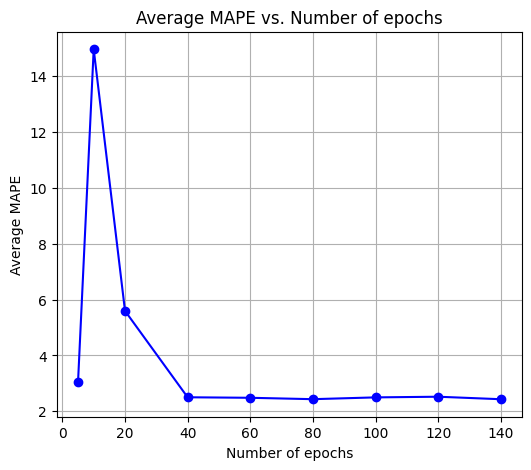

In [35]:
# Create a line plot
plt.figure(figsize=(6, 5))
plt.plot(epochs, avg_percentages_diffs_epochs, marker='o', linestyle='-', color='blue')
plt.title('Average MAPE vs. Number of epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Average MAPE')
plt.grid(True)
plt.savefig('epochs.pdf', format='pdf', bbox_inches='tight')


# Show the plot
plt.show()

### R&D ESTIMATION ON A QUARTERLY BASIS (GOOGLE TRENDS DATA)

In [36]:
def extracts_google_trends_quarterly_data(merged_data_google_trends, features_kept):
    """
    Extract quarterly Google Trends data from a merged DataFrame.

    This function extracts quarterly Google Trends data (specified by quartiles) from the merged DataFrame
    'merged_data_google_trends'. It also calculates the sum of features for each quarter and returns separate
    DataFrames for each quarter (quarter1, quarter2, quarter3, quarter4) and the sum across all quarters (quartersum).

    Parameters:
        merged_data_google_trends (pandas.DataFrame): The merged DataFrame containing Google Trends data.
        features_kept (list of str): List of feature column names to be retained.

    Returns:
        tuple of DataFrames: A tuple containing the following DataFrames:
            - quarter1: DataFrame containing data for the first quartile.
            - quarter2: DataFrame containing data for the second quartile.
            - quarter3: DataFrame containing data for the third quartile.
            - quarter4: DataFrame containing data for the fourth quartile.
            - quartersum: DataFrame containing the sum of features across all quarters.
    """
    # Keep only relevant columns and reset the index
    df = merged_data_google_trends.loc[:, features_kept + ["ISO", "year", "quartile"]].reset_index(drop=True)
    
    # Extracting quartile 1
    quarter1 = df[df["quartile"] == 1]
    quarter1 = quarter1.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter1.columns = [col + "_1" if col != "ISO" and col != "year" else col for col in quarter1.columns ]

    # Extracting quartile 2
    quarter2 = df[df["quartile"] == 2]
    quarter2 = quarter2.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter2.columns = [col + "_2" if col != "ISO" and col != "year" else col for col in quarter2.columns ]

    # Extracting quartile 3
    quarter3 = df[df["quartile"] == 3]
    quarter3 = quarter3.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter3.columns = [col + "_3" if col != "ISO" and col != "year" else col for col in quarter3.columns ]

    # Extracting quartile 4
    quarter4 = df[df["quartile"] == 4]
    quarter4 = quarter4.drop(axis=1, columns=["quartile"])
    # Renaming the columns to reflect which quarter this dataframe represents
    quarter4.columns = [col + "_4" if col != "ISO" and col != "year" else col for col in quarter4.columns ]

    # Calculate the sum of features for each quarter and reset the index
    quartersum = df.groupby(["ISO", "year"]).sum()
    quartersum = quartersum.drop(axis=1, columns=["quartile"])
    quartersum = quartersum.reset_index()
    quartersum.columns = [col + "_sum" if col != "ISO" and col != "year" else col for col in quartersum.columns ]

    return quarter1, quarter2, quarter3, quarter4, quartersum


In [37]:
quarter1,quarter2,quarter3,quarter4,quartersum = extracts_google_trends_quarterly_data(merged_data_google_trends,features_kept) 


In [38]:
#Grouping all the quartiles dataframe together , this will be useful to train the model , and evaluate it later
merged_quartiles = pd.merge(quarter1, quarter2, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quarter3, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quarter4, on=["ISO", "year"], how='inner')
merged_quartiles = pd.merge(merged_quartiles, quartersum, on=["ISO", "year"], how='inner')

merged_quartiles

Web Apps & Online Tools_1  Business Finance_1  \
0                    68.333333           94.666667   
1                    84.000000           81.000000   
2                    53.333333           78.666667   
3                    68.000000           93.333333   
4                    49.333333           84.333333   
..                         ...                 ...   
139                  68.000000           69.333333   
140                  42.000000            0.000000   
141                  75.666667           54.000000   
142                  40.666667           67.666667   
143                  55.333333           65.333333   

     Pharmaceutical Manufacturing_1  Data Management_y_1  Venture Capital_1  \
0                         94.000000            85.000000          51.666667   
1                         89.000000            89.333333          26.000000   
2                         83.666667            74.333333          36.000000   
3                         77.333333            91.666667          36.000000   
4                         63.000000            92.666667          15.333333   
..                              ...                  ...                ...   
139                       88.333333            64.333333           7.333333   
140                        0.000000            50.333333          19.333333   
141                       77.666667            33.000000           6.000000   
142                       62.333333             0.000000          60.333333   
143                       61.666667            53.000000          18.000000   

     Pharmaceuticals & Biotech_1  Genetics_1  Automotive Industry_1  \
0                      96.333333   86.333333              82.333333   
1                      92.000000   95.000000              79.000000   
2                      74.000000    0.000000              83.666667   
3                      94.666667   87.666667              91.666667   
4                      91.333333   95.333333              94.666667   
..                           ...         ...                    ...   
139                    68.666667   42.000000              38.333333   
140                    29.666667   27.000000              39.666667   
141                    40.000000   41.666667              47.666667   
142                    57.666667   29.333333              25.666667   
143                    27.000000   37.000000              30.666667   

     Nanobiotechnology_1  Software Utilities_1  ...  Genetics_sum  \
0              97.333333             95.000000  ...    305.666667   
1              95.333333             82.333333  ...    336.666667   
2              75.333333             90.666667  ...      0.000000   
3              94.666667             72.333333  ...    307.000000   
4              98.000000             84.333333  ...    325.333333   
..                   ...                   ...  ...           ...   
139            45.333333             32.000000  ...    172.000000   
140            27.666667             46.000000  ...    100.000000   
141            39.666667             38.666667  ...    181.666667   
142            43.666667             90.000000  ...    123.666667   
143            34.333333             53.666667  ...    124.666667   

     Automotive Industry_sum  Nanobiotechnology_sum  Software Utilities_sum  \
0                 325.666667             336.000000              332.666667   
1                 316.333333             346.000000              278.666667   
2                 318.666667             307.666667              335.000000   
3                 343.666667             344.000000              266.666667   
4                 330.666667             345.000000              279.333333   
..                       ...                    ...                     ...   
139               158.666667             174.333333              124.666667   
140               141.000000             103.666667              174.666667   
141           

In [39]:
#Merging google trends data with R&D expanditures 
google_trends_R_D = pd.merge(first_merged, merged_quartiles, on=['ISO', 'year'], how='inner')
google_trends_R_D = google_trends_R_D.drop(axis =1 ,columns=["ISO","year","v-2"])

#Keep  a copy of this dataframe with quarterly basis data, this will be useful to evaluate our model on a quarterly basis
quartiles_data_frame = google_trends_R_D.copy()

# columns to keep that we will be using to train our model(only columns that represents sums of google trends data),
# also v-1, and v which will be used to evaluate our models 
cols_to_keep = []
for col in google_trends_R_D.columns :
    if col =="v-1" or col=="v" or col.split("_")[-1]=="sum":
        cols_to_keep.append(col)

google_trends_R_D = google_trends_R_D.loc[:,cols_to_keep]
google_trends_R_D

v-1         v  Web Apps & Online Tools_sum  Business Finance_sum  \
0    1.971243 -0.028245                   278.666667            326.666667   
1    1.942999 -0.039421                   306.666667            293.000000   
2    1.903578 -0.047800                   336.000000            288.666667   
3    1.855778  0.061638                   302.000000            249.666667   
4    1.917415 -0.092138                   303.333333            247.000000   
..        ...       ...                          ...                   ...   
123  2.853501  0.050823                   236.666667            201.666667   
124  2.904324  0.105778                   235.000000            231.333333   
125  3.010102  0.160385                   235.000000            224.666667   
126  3.170487  0.297284                   228.000000            234.000000   
127  3.467771 -0.010725                   212.333333            274.333333   

     Pharmaceutical Manufacturing_sum  Data Management_y_sum  \
0                          327.333333             304.666667   
1                          308.333333             327.666667   
2                          277.333333             302.000000   
3                          227.000000             232.666667   
4                          232.666667             195.666667   
..                                ...                    ...   
123                        225.666667             215.000000   
124                        243.666667             225.666667   
125                        238.000000             216.000000   
126                        232.333333             207.000000   
127                        220.333333             208.333333   

     Venture Capital_sum  Pharmaceuticals & Biotech_sum  Genetics_sum  \
0             179.000000                     340.666667    305.666667   
1             155.333333                     297.000000    295.333333   
2             135.000000                     278.333333    271.666667   
3             105.333333                     221.333333    237.333333   
4              86.666667                     206.333333    204.333333   
..                   ...                            ...           ...   
123            75.333333                     106.000000    147.333333   
124            78.000000                     106.666667    155.000000   
125            71.000000                     101.666667    148.666667   
126            72.000000                     102.000000    137.000000   
127            63.000000                     117.666667    124.666667   

     Automotive Industry_sum  Nanobiotechnology_sum  Software Utilities_sum  \
0                 325.666667             336.000000              332.666667   
1                 276.666667             272.000000              293.000000   
2                 233.666667             221.666667              290.000000   
3                 233.666667             168.333333              236.000000   
4                 199.000000             139.000000              210.000000   
..                       ...                    ...                     ...   
123                98.333333             149.333333              200.000000   
124               102.666667             152.000000              207.000000   
125               110.000000             144.000000              199.333333   
126               134.666667             140.333333              200.666667   
127               108.000000             149.333333              204.333333   

     Oil & Gas_sum  Renewable Energy_sum  \
0       337.000000            335.000000   
1       309.666667            307.666667   
2       308.666667            312.333333   
3       272.666667            272.000000   
4       226.333333            234.666667   
..             ...                   ...   
123     153.333333            153.666667   
124     154.333333            154.000000   
125     144.666667            144.666667   
126     147.666667            147.0000

In [40]:
def extract_quarterly_based_dataframes(X_test, merged_quartiles):
    """
    Extract quarterly-based DataFrames from a merged quartiles DataFrame.

    This function takes the testing data X_test and extracts separate DataFrames for each quarter (1, 2, 3, 4) based on the
    provided merged quartiles DataFrame. The DataFrames are filtered to include only columns corresponding to the respective
    quarters.

    Parameters:
        X_test (pandas.DataFrame): The testing data for which quarterly-based DataFrames are extracted.
        merged_quartiles (pandas.DataFrame): The merged quartiles DataFrame containing features for all quarters.

    Returns:
        tuple of DataFrames: A tuple containing the following DataFrames:
            - X_test_quarter1: DataFrame containing data for the first quarter.
            - X_test_quarter2: DataFrame containing data for the second quarter.
            - X_test_quarter3: DataFrame containing data for the third quarter.
            - X_test_quarter4: DataFrame containing data for the fourth quarter.
    """
    # Extracting data for quarter 1
    X_test_quarter1 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep1 = [col for col in X_test_quarter1.columns if col.split("_")[-1] == "1"]
    X_test_quarter1 = X_test_quarter1.loc[:, cols_to_keep1]

    # Extracting data for quarter 2
    X_test_quarter2 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep2 = [col for col in X_test_quarter2.columns if col.split("_")[-1] == "2"]
    X_test_quarter2 = X_test_quarter2.loc[:, cols_to_keep2]

    # Extracting data for quarter 3
    X_test_quarter3 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep3 = [col for col in X_test_quarter3.columns if col.split("_")[-1] == "3"]
    X_test_quarter3 = X_test_quarter3.loc[:, cols_to_keep3]

    # Extracting data for quarter 4
    X_test_quarter4 = merged_quartiles.loc[X_test.index.values]
    cols_to_keep4 = [col for col in X_test_quarter4.columns if col.split("_")[-1] == "4"]
    X_test_quarter4 = X_test_quarter4.loc[:, cols_to_keep4]

    return X_test_quarter1, X_test_quarter2, X_test_quarter3, X_test_quarter4


In [41]:
def train_and_evaluate_quarterly_basis(df, n_folds, merged_quartiles):
    """
    Train and evaluate a model on a quarterly basis using cross-validation.

    This function performs training and evaluation on a given DataFrame `df` with quarterly data using cross-validation.
    It splits the data into `n_folds` folds and calculates the average percentage difference between true and predicted
    R&D expenditure values for each fold.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing R&D expenditure data with quarterly features.
        n_folds (int): The number of folds for cross-validation.
        merged_quartiles (pandas.DataFrame): The DataFrame containing merged quartile-based features.

    Returns:
        None
    """
    fold = 0
    avg_percentages_diffs = []

    # Loop through each fold of cross-validation
    for (train_index, test_index) in cross_validation_indices(df, n_folds):
        
        # Split the data into training and test sets for the current fold
        train_df = df.iloc[train_index]
        train_df = train_df[:]
        test_df = df.iloc[test_index]
        
        # Prepare input data and target data
        X_train = train_df.drop(['v', 'v-1'], axis=1)
        y_train = train_df['v']
        previous_R_D_values = test_df["v-1"]
        X_test = test_df.drop(['v', 'v-1'], axis=1)
        y_test = test_df['v']
        input_shape = X_train.shape[1]
        
        # Train an NLP model
        model,_ = NN_optimized(X_train, y_train, input_shape)
        
        # Extract quarterly-based DataFrames for testing data
        X_test_quarter1, X_test_quarter2, X_test_quarter3, X_test_quarter4 = extract_quarterly_based_dataframes(X_test, merged_quartiles)
        
        # Make predictions for each quarter
        y_pred_quarter1 = model.predict(X_test_quarter1)
        y_pred_quarter2 = model.predict(X_test_quarter2)
        y_pred_quarter3 = model.predict(X_test_quarter3)
        y_pred_quarter4 = model.predict(X_test_quarter4)
        
        # Calculate true and predicted R&D expenditure values for the entire year
        R_D_true_values = previous_R_D_values + y_test
        R_D_predicted_values = previous_R_D_values + y_pred_quarter1.flatten() + y_pred_quarter2.flatten() + y_pred_quarter3.flatten() + y_pred_quarter4.flatten()
        
        # Calculate the average percentage difference for the current fold
        avg_percentage_diff = np.mean((np.abs(R_D_true_values - R_D_predicted_values) / R_D_true_values * 100))
        print(f"the MAPE for the {fold}th fold is : {avg_percentage_diff}%")
        
        # Store the average percentage difference for this fold
        avg_percentages_diffs.append(avg_percentage_diff)
        fold += 1
    
    # Calculate the overall average percentage difference across all folds
    avg_percentage_diff_folds = sum(avg_percentages_diffs) / n_folds 
    print(f"the MAPE for this training is : {avg_percentage_diff_folds}%")
    return avg_percentage_diff_folds


In [42]:
train_and_evaluate_quarterly_basis(google_trends_R_D,5,merged_quartiles)

Epoch 1/80
11/11 [==============================] - 2s 44ms/step - loss: 864.7054 - val_loss: 47.3431 - lr: 0.0010
Epoch 2/80
11/11 [==============================] - 0s 35ms/step - loss: 155.5013 - val_loss: 102.7061 - lr: 0.0010
Epoch 3/80
11/11 [==============================] - 0s 36ms/step - loss: 42.1786 - val_loss: 52.1107 - lr: 0.0010
Epoch 4/80
11/11 [==============================] - 0s 36ms/step - loss: 14.2153 - val_loss: 12.4679 - lr: 0.0010
Epoch 5/80
11/11 [==============================] - 0s 32ms/step - loss: 7.4291 - val_loss: 1.2390 - lr: 0.0010
Epoch 6/80
11/11 [==============================] - 0s 34ms/step - loss: 1.7344 - val_loss: 0.7219 - lr: 0.0010
Epoch 7/80
11/11 [==============================] - 0s 34ms/step - loss: 0.4126 - val_loss: 0.3110 - lr: 0.0010
Epoch 8/80
11/11 [==============================] - 0s 33ms/step - loss: 0.1062 - val_loss: 0.3985 - lr: 0.0010
Epoch 9/80
11/11 [==============================] - 0s 36ms/step - loss: 0.2203 - val_loss: 0

Epoch 72/80
11/11 [==============================] - 0s 43ms/step - loss: 0.0094 - val_loss: 0.1020 - lr: 5.5166e-06
Epoch 73/80
11/11 [==============================] - 0s 34ms/step - loss: 0.0094 - val_loss: 0.1000 - lr: 4.9916e-06
Epoch 74/80
11/11 [==============================] - 0s 31ms/step - loss: 0.0100 - val_loss: 0.0902 - lr: 4.5166e-06
Epoch 75/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0096 - val_loss: 0.0947 - lr: 4.0868e-06
Epoch 76/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0093 - val_loss: 0.0991 - lr: 3.6979e-06
Epoch 77/80
11/11 [==============================] - 0s 35ms/step - loss: 0.0093 - val_loss: 0.0949 - lr: 3.3460e-06
Epoch 78/80
11/11 [==============================] - 0s 33ms/step - loss: 0.0094 - val_loss: 0.0965 - lr: 3.0276e-06
Epoch 79/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0093 - val_loss: 0.0982 - lr: 2.7394e-06
Epoch 80/80
1/1 [==============================] - 0s 29ms/step


11/11 [==============================] - 0s 27ms/step - loss: 0.0116 - val_loss: 0.0649 - lr: 1.8316e-05
Epoch 61/80
11/11 [==============================] - 0s 32ms/step - loss: 0.0115 - val_loss: 0.0659 - lr: 1.6573e-05
Epoch 62/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0113 - val_loss: 0.0709 - lr: 1.4996e-05
Epoch 63/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0653 - lr: 1.3569e-05
Epoch 64/80
11/11 [==============================] - 0s 35ms/step - loss: 0.0114 - val_loss: 0.0646 - lr: 1.2277e-05
Epoch 65/80
11/11 [==============================] - 0s 35ms/step - loss: 0.0111 - val_loss: 0.0747 - lr: 1.1109e-05
Epoch 66/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0117 - val_loss: 0.0692 - lr: 1.0052e-05
Epoch 67/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0113 - val_loss: 0.0648 - lr: 9.0953e-06
Epoch 68/80
11/11 [==============================] - 0s 29ms/step - loss: 0.

11/11 [==============================] - 0s 26ms/step - loss: 0.0153 - val_loss: 0.0225 - lr: 6.0810e-05
Epoch 49/80
11/11 [==============================] - 0s 30ms/step - loss: 0.0094 - val_loss: 0.0202 - lr: 5.5023e-05
Epoch 50/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0082 - val_loss: 0.0185 - lr: 4.9787e-05
Epoch 51/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0084 - val_loss: 0.0190 - lr: 4.5049e-05
Epoch 52/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0092 - val_loss: 0.0217 - lr: 4.0762e-05
Epoch 53/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0189 - lr: 3.6883e-05
Epoch 54/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0182 - lr: 3.3373e-05
Epoch 55/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0202 - lr: 3.0197e-05
Epoch 56/80
11/11 [==============================] - 0s 25ms/step - loss: 0.

11/11 [==============================] - 0s 26ms/step - loss: 0.0107 - val_loss: 0.0625 - lr: 2.0190e-04
Epoch 37/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0117 - val_loss: 0.1117 - lr: 1.8268e-04
Epoch 38/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0193 - val_loss: 0.0549 - lr: 1.6530e-04
Epoch 39/80
11/11 [==============================] - 0s 25ms/step - loss: 0.0173 - val_loss: 0.0723 - lr: 1.4957e-04
Epoch 40/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0086 - val_loss: 0.0585 - lr: 1.3534e-04
Epoch 41/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 0.0944 - lr: 1.2246e-04
Epoch 42/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0096 - val_loss: 0.0785 - lr: 1.1080e-04
Epoch 43/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0087 - val_loss: 0.0786 - lr: 1.0026e-04
Epoch 44/80
11/11 [==============================] - 0s 21ms/step - loss: 0.

11/11 [==============================] - 0s 23ms/step - loss: 0.0299 - val_loss: 0.0202 - lr: 6.7032e-04
Epoch 25/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0180 - val_loss: 0.0297 - lr: 6.0653e-04
Epoch 26/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0216 - val_loss: 0.0249 - lr: 5.4881e-04
Epoch 27/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0182 - val_loss: 0.0239 - lr: 4.9659e-04
Epoch 28/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0157 - val_loss: 0.0227 - lr: 4.4933e-04
Epoch 29/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0212 - val_loss: 0.0222 - lr: 4.0657e-04
Epoch 30/80
11/11 [==============================] - 0s 30ms/step - loss: 0.0186 - val_loss: 0.0300 - lr: 3.6788e-04
Epoch 31/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0133 - val_loss: 0.0201 - lr: 3.3287e-04
Epoch 32/80
11/11 [==============================] - 0s 28ms/step - loss: 0.

4.605888301915888